In [1]:
# Preprocessing
from sklearn import preprocessing
import xgboost as xgb

# modules to handle data
import os
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import pickle
import gc

%matplotlib inline
import matplotlib.pyplot as plt

# Create submission file with assigned predicted results from models
def create_file_for_submission(filename, classifier_predictions):
    kaggle_submission = pd.read_csv('./datasets/IEEEFraudDetection/sample_submission.csv', index_col='TransactionID')

    # Probabilities of class 2 ('isFraud'=1) is in column 1 of the matrix
    kaggle_submission['isFraud'] = classifier_predictions[:,1]
    kaggle_submission.to_csv(filename)
    
def load_classifier_from_picklefile(filename):
    infile = open(filename,'rb')
    loaded_Classifier = pickle.load(infile)
    infile.close()
    return loaded_Classifier
    
def save_classifier_to_picklefile(filename, save_Classifier):
    model_file = open(filename,'wb')
    pickle.dump(save_Classifier, model_file)
    model_file.close()

In [2]:
# load data 
train_identity = pd.read_csv('./datasets/IEEEFraudDetection/train_identity.csv', index_col='TransactionID')
train_transaction = pd.read_csv('./datasets/IEEEFraudDetection/train_transaction.csv', index_col='TransactionID')

test_identity = pd.read_csv('./datasets/IEEEFraudDetection/test_identity.csv', index_col='TransactionID')
test_transaction = pd.read_csv('./datasets/IEEEFraudDetection/test_transaction.csv', index_col='TransactionID')

In [3]:
# train_transaction.head(), train_identity.head()
# test_identity.head(), test_transaction.head()
print("Shape of train_identity : ", train_identity.shape)
print("Shape of train_transaction : ", train_transaction.shape)
print("Shape of test_identity : ", test_identity.shape)
print("Shape of test_transaction : ", test_transaction.shape)

Shape of train_identity :  (144233, 40)
Shape of train_transaction :  (590540, 393)
Shape of test_identity :  (141907, 40)
Shape of test_transaction :  (506691, 392)


In [4]:
train_merged = train_transaction.merge(train_identity,
                                       how='left', left_index=True, right_index=True)
test_merged = test_transaction.merge(test_identity,
                                     how='left',left_index=True, right_index=True)

print("Shape of train_merged : ", train_merged.shape)
print("Shape of test_merged : ", test_merged.shape)

Shape of train_merged :  (590540, 433)
Shape of test_merged :  (506691, 432)


# Transaction columns (394 items including 'TransactionID')

1. TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD,
2. card1 - card6,
3. addr1 - addr2,
4. dist1 - dist2,
5. P_emaildomain, R_emaildomain,
6. C1 - C14,
7. D1 - D15,
8. M1 - M9,
9. V1 - V339

# Identity columns (41 items including 'TransactionID')
1. TransactionID,
2. id_01 - id_38,
3. DeviceType, DeviceInfo

In [5]:
# test_merged[19900:19910]
print("Merged DataFrame shape :", train_merged.shape)
train_merged.head()

Merged DataFrame shape : (590540, 433)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
# Initialized variables
total_counts = len(train_merged)

missing_data_pc = ((train_merged.isnull().sum() / total_counts) * 100).round(2).astype(str) + "%"
missing_data_pc.index

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

In [7]:
# Print all values in data
sorted_missing_data_pc = missing_data_pc.sort_values(ascending=False)

print("Missing values in data :\n" + sorted_missing_data_pc.to_string())
print("\nTotal number of columns :", len(sorted_missing_data_pc))

Missing values in data :
id_24              99.2%
id_26             99.13%
id_21             99.13%
id_07             99.13%
id_25             99.13%
id_08             99.13%
id_23             99.12%
id_27             99.12%
id_22             99.12%
dist2             93.63%
D7                93.41%
id_18             92.36%
D13               89.51%
D14               89.47%
D12               89.04%
id_04             88.77%
id_03             88.77%
D6                87.61%
id_33             87.59%
D8                87.31%
D9                87.31%
id_10             87.31%
id_09             87.31%
id_30             86.87%
id_32             86.86%
id_34             86.82%
id_14             86.45%
V151              86.12%
V152              86.12%
V153              86.12%
V154              86.12%
V155              86.12%
V156              86.12%
V164              86.12%
V157              86.12%
V158              86.12%
V159              86.12%
V160              86.12%
V161              86.12%


In [8]:
total_num_features = len(sorted_missing_data_pc)
selected_num_features = 0
selected_features_above_threshold = []
for ctr in range(total_num_features):
    float_val = float(sorted_missing_data_pc[ctr].rstrip('%'))
    if float_val > 90.00 :
        selected_num_features += 1
        selected_features_above_threshold.append(sorted_missing_data_pc.index[ctr])
        #print("'" + sorted_missing_data_pc.index[ctr] + "',") #, " :", correlation_fraud[ctr])

# Get the balance features after dropping columns above threshold
selected_balance_features = train_merged.columns.difference(selected_features_above_threshold)

print("Total no. of features :", len(train_merged.columns))
print("Total no. of selected features above threshold :", selected_num_features)
print("Selected features above missing thresholds and to be dropped :\n",selected_features_above_threshold)

# compared with these 51 columns
# drop_col = ['TransactionDT',
#            'V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102',
#            'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318',
#            'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104',
#            'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105',
#            'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120',
#            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

Total no. of features : 433
Total no. of selected features above threshold : 12
Selected features above missing thresholds and to be dropped :
 ['id_24', 'id_26', 'id_21', 'id_07', 'id_25', 'id_08', 'id_23', 'id_27', 'id_22', 'dist2', 'D7', 'id_18']


In [9]:
total_num_selected_balance_features = len(selected_balance_features)
selected_balance_features_array = []
for ctr in range(total_num_selected_balance_features):
    selected_balance_features_array.append(selected_balance_features[ctr])

print("Total no. of balance features :", total_num_selected_balance_features)
print("Balance features after dropping features :\n", selected_balance_features_array)

Total no. of balance features : 421
Balance features after dropping features :
 ['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'DeviceInfo', 'DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'TransactionAmt', 'TransactionDT', 'V1', 'V10', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V11', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V12', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V13', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V14', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162', 'V163', 'V164', '

In [10]:
def plot_topmost_parm(source_df, col_name, total_items, display_topmost, text_padding):
    col_Grp = pd.DataFrame()
    col_Grp['grpCount'] = source_df.groupby([col_name])[col_name].count()
    col_Grp[col_name] = col_Grp.index

    # There are too many card1, so we will subset the top group
    col_grp_top = col_Grp.sort_values(by='grpCount',ascending=False).head(display_topmost)
    order_grp = col_grp_top.sort_values(by='grpCount',ascending=False)[col_name]

    plt.figure(figsize=(25, 10))
    sns.set(color_codes=True)
    sns.set(font_scale = 1.3)
    ax = sns.barplot(x=col_name, y='grpCount', data=col_grp_top, order=order_grp)
    ax.set_title("Top " + str(display_topmost) + " ranking of " + col_name, fontsize=18)
    for rectBox in ax.patches:
        count = rectBox.get_height()
        #print("Counts :", count)    
        ax.text(rectBox.get_x() + rectBox.get_width()/2.,
                count + text_padding,
                '{:1.2f}%'.format(count/total_items*100),
                ha="center", fontsize=11)

    xt = plt.xticks(rotation=60)
    plt.show()

    print("Total no. of " + col_name + " :", len(col_Grp.index))
    print("Missing Data for " + col_name + " : " +
          '{:1.2f}%'.format(source_df[col_name].isnull().sum() / total_items * 100))
    #print("Top " + str(display_topmost) + " :\n", col_grp_top[col_name])

    for ctr in range(len(col_grp_top)):
        if (col_grp_top.iloc[ctr][col_name] == -999):
            print("Found in Index", str(ctr) + " :", col_grp_top.iloc[ctr]['grpCount'])
            print("Missing Data : " + '{:1.2f}%'.format(col_grp_top.iloc[ctr]['grpCount'] / total_items * 100))

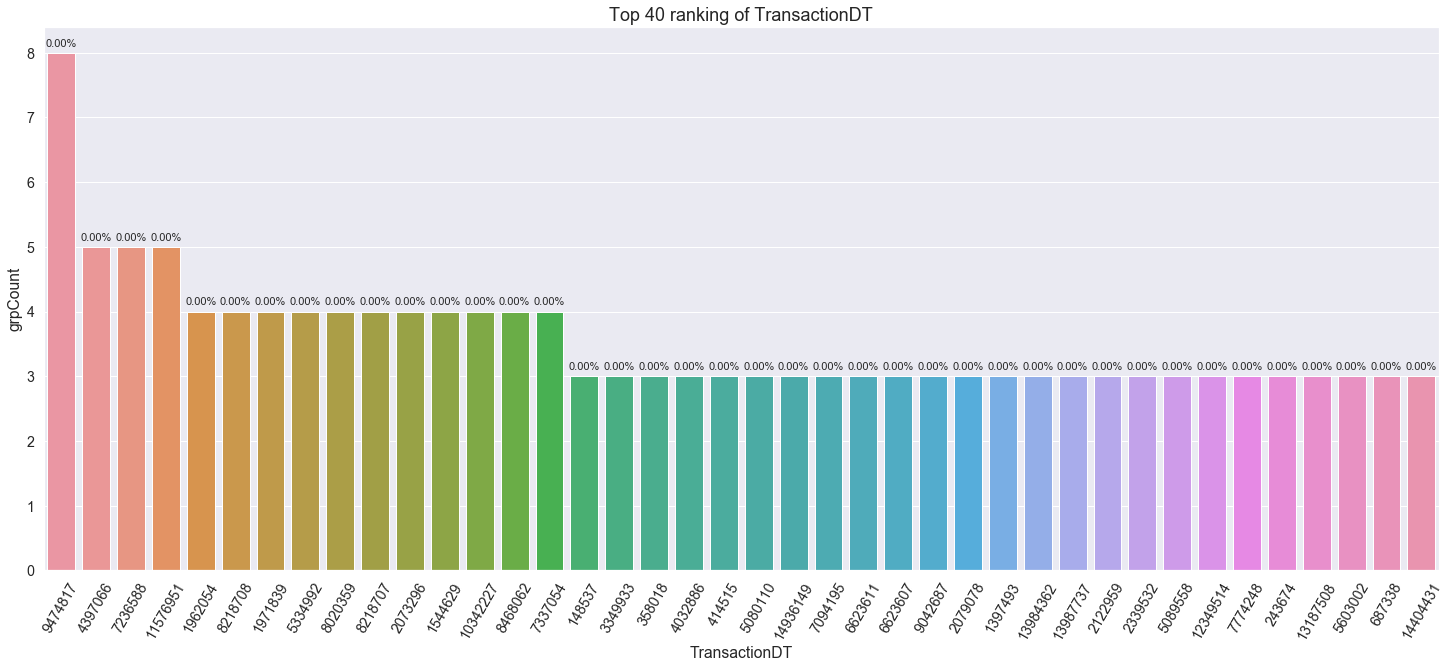

Total no. of TransactionDT : 573349
Missing Data for TransactionDT : 0.00%


In [11]:
# Plot TransactionDT details
plot_topmost_parm(source_df=train_merged, col_name='TransactionDT', total_items=len(train_merged), display_topmost=40, text_padding=0.1)

In [12]:
def make_day_feature(df, offset=0, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    offset : float (default=0)
        offset (in days) to shift the start/end of a day.
    tname : str
        Name of the time column in df.
    """
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

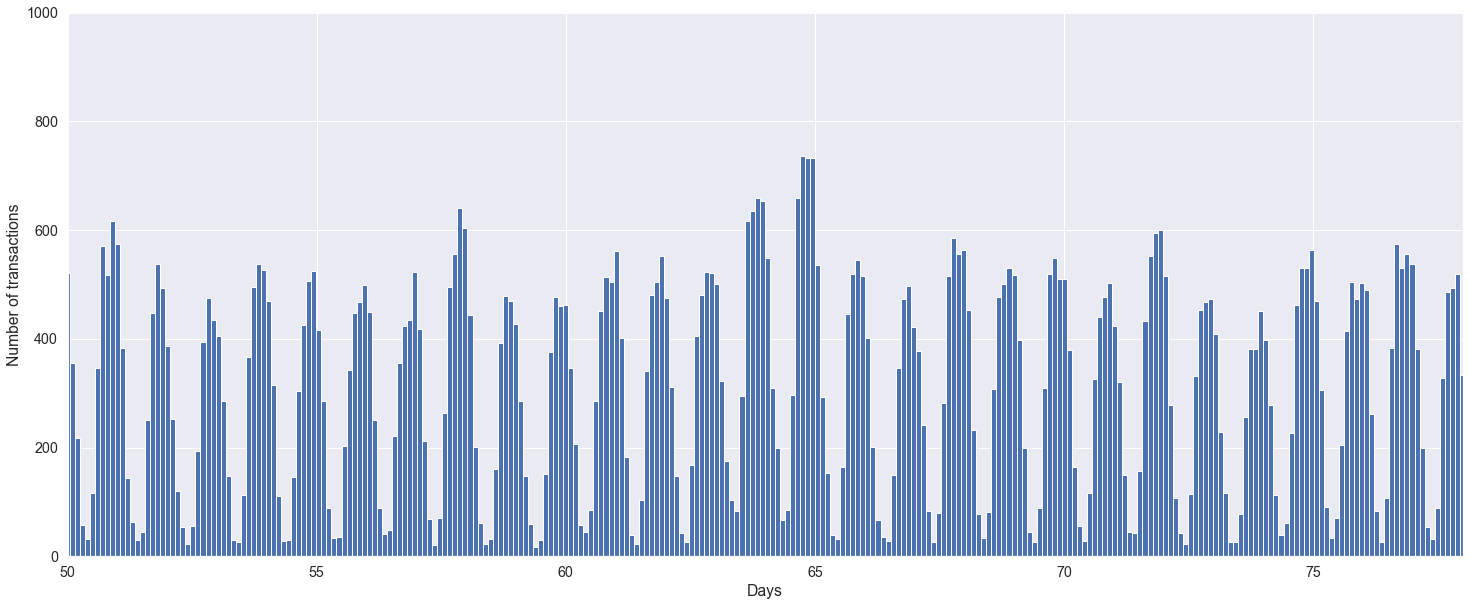

(array([510., 317., 188., ..., 455., 433., 421.]), array([  1.        ,   1.10111067,   1.20222133, ..., 182.79698005,
       182.89809072, 182.99920139]), <a list of 1800 Patch objects>)


In [13]:
fig = plt.figure(figsize=(25, 10)) 
ax = plt.axes()

# bins defines the number of bins that data will be divided into
array_vals = plt.hist(train_merged['TransactionDT'] / (3600*24), bins=1800)

# set range
ax.set_xlim([50, 78])
plt.xlabel('Days')
plt.ylabel('Number of transactions')

plt.ylim(0,1000)
plt.show()

print(array_vals)

In [14]:
train_merged['weekday'] = make_day_feature(train_merged, offset=0.58)
test_merged['weekday'] = make_day_feature(test_merged, offset=0.58)

train_merged.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.0


In [15]:
# Same result as weekday_counts_byFraud = (train_merged.groupby('weekday')['isFraud'].count())
weekday_counts = (train_merged.groupby('weekday').count())
weekday_counts

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
weekday,,,,,,,,,,,,,,,,,,,,,
0.0,86311,86311,86311,86311,86311,85112,86311,86309,85893,86309,...,20909,10580,9965,10623,21027,21027,21027,21027,20933,17437
1.0,98920,98920,98920,98920,98920,97703,98914,98911,98486,98914,...,22121,11892,11143,11891,22165,22165,22165,22165,22160,18719
2.0,75438,75438,75438,75438,75438,74414,75436,75436,75080,75434,...,18480,10480,9914,10506,18520,18520,18520,18520,18516,15670
3.0,74558,74558,74558,74558,74558,73718,74557,74553,74252,74556,...,20384,12252,11643,12384,20694,20694,20694,20694,20678,17450
4.0,86283,86283,86283,86283,86283,85268,86282,86281,85871,86281,...,20354,11814,11170,11813,20422,20422,20422,20422,20414,17328
5.0,83596,83596,83596,83596,83596,81836,82855,82853,82458,82855,...,18679,10113,9580,10102,18727,18727,18727,18727,18721,15733
6.0,85434,85434,85434,85434,85434,83556,84620,84620,84241,84620,...,19355,10455,9874,10486,19430,19430,19430,19430,19388,16329


In [16]:
# Empty values in some columns
weekday_counts.sum(), train_merged.shape

(isFraud           590540
 TransactionDT     590540
 TransactionAmt    590540
 ProductCD         590540
 card1             590540
                    ...  
 id_36             140985
 id_37             140985
 id_38             140985
 DeviceType        140810
 DeviceInfo        118666
 Length: 433, dtype: int64, (590540, 434))

In [17]:
weekday_mean_values = (train_merged.groupby('weekday').mean())
weekday_mean_values

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
weekday,,,,,,,,,,,,,,,,,,,,,
0.0,0.037724,7.551865e+06,142.992850,9874.683690,361.521619,153.629271,198.155077,290.937094,86.777842,119.475640,...,192.080673,14.190386,348.267693,406.215323,399.691790,16.052490,12.938144,322.793243,151.049798,26.102836
1.0,0.034917,7.036271e+06,146.872307,9842.479226,360.866350,153.247124,199.112148,290.577648,86.840514,122.249034,...,190.532804,14.201105,351.977321,405.505935,396.478212,16.291620,13.053416,320.052750,150.555307,26.283888
2.0,0.036825,7.073271e+06,120.920556,9862.000782,361.616672,153.142571,200.749867,291.255004,86.834175,117.175857,...,188.679861,14.361425,348.850098,404.775547,307.563158,15.661404,12.344322,324.083039,142.889474,27.220611
3.0,0.032954,7.250272e+06,105.144140,9973.986360,365.162023,153.216371,198.920298,290.885826,86.871533,119.216108,...,186.961676,14.416945,365.546000,407.692266,313.162749,15.394213,12.515209,325.312839,146.473779,26.964414
4.0,0.032683,7.440582e+06,138.025118,9916.521122,364.787904,152.948413,200.102188,290.838624,86.793132,112.344400,...,188.062135,14.213182,352.545797,399.300441,364.218826,16.317518,12.721180,338.103785,150.066991,26.614525
5.0,0.032466,7.629774e+06,141.016411,9911.451002,361.938804,153.001267,198.964552,290.335506,86.739511,119.550642,...,189.854735,14.187220,350.916829,403.442244,382.547244,16.266927,12.722535,343.767196,150.895151,26.179373
6.0,0.037269,7.629682e+06,142.911644,9924.526020,362.446036,153.159631,199.093244,290.407363,86.754017,118.945239,...,189.828140,14.125351,353.378942,399.859998,379.172372,15.726161,13.097959,331.344486,149.007335,26.125681


In [18]:
# Only showing weekdays with mean 'isFraud' value that includes both "0" and "1" values of 'isFraud'
weekday_mean_values = (train_merged.groupby('weekday').mean()['isFraud'])
weekday_mean_values

weekday
0.0    0.037724
1.0    0.034917
2.0    0.036825
3.0    0.032954
4.0    0.032683
5.0    0.032466
6.0    0.037269
Name: isFraud, dtype: float64

Text(0, 0.5, 'Mean of fraudulent transactions')

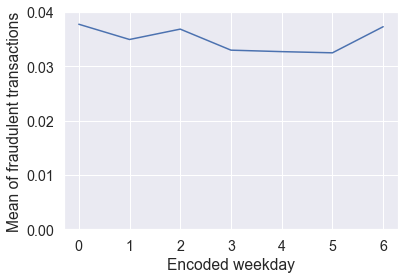

In [19]:
plt.plot(train_merged.groupby('weekday').mean()['isFraud'])

plt.ylim(0, 0.04)
plt.xlabel('Encoded weekday')
plt.ylabel('Mean of fraudulent transactions')

In [20]:
train_merged['hours'] = make_hour_feature(train_merged)
test_merged['hours'] = make_day_feature(test_merged, offset=0.58)

#train_merged.groupby('hours').mean()
train_merged.groupby('hours').mean()['isFraud']

hours
0.0     0.031380
1.0     0.031314
2.0     0.037483
3.0     0.038314
4.0     0.051890
5.0     0.070302
6.0     0.077743
7.0     0.106102
8.0     0.093014
9.0     0.089956
10.0    0.053212
11.0    0.038816
12.0    0.030439
13.0    0.022889
14.0    0.024216
15.0    0.025399
16.0    0.029511
17.0    0.031530
18.0    0.035231
19.0    0.034738
20.0    0.034273
21.0    0.034005
22.0    0.032694
23.0    0.036997
Name: isFraud, dtype: float64

In [21]:
# No. of transactions at different hour interval including both fraudulent and non-fraudulent transactions
train_merged.groupby('hours')['isFraud'].count()

hours
0.0     37795
1.0     32797
2.0     26732
3.0     20802
4.0     14839
5.0      9701
6.0      6007
7.0      3704
8.0      2591
9.0      2479
10.0     3627
11.0     6827
12.0    12451
13.0    20315
14.0    28328
15.0    33859
16.0    38698
17.0    40723
18.0    41639
19.0    42115
20.0    41782
21.0    41641
22.0    41139
23.0    39949
Name: isFraud, dtype: int64

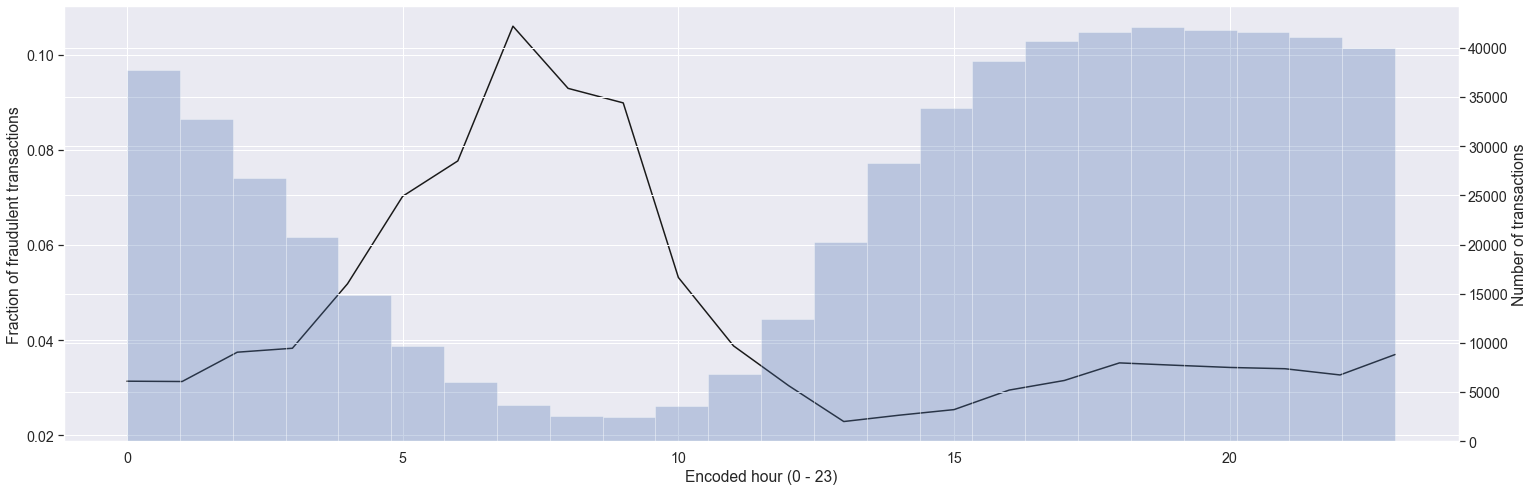

(array([37795., 32797., 26732., 20802., 14839.,  9701.,  6007.,  3704.,
        2591.,  2479.,  3627.,  6827., 12451., 20315., 28328., 33859.,
       38698., 40723., 41639., 42115., 41782., 41641., 41139., 39949.]), array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
        4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
        9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
       14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
       19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]), <a list of 24 Patch objects>)


In [22]:
fig = plt.figure(figsize=(25, 8)) 
plt.plot(train_merged.groupby('hours').mean()['isFraud'], color='k') # The solid black graph

ax = plt.gca()   # Get the current Axes instance on the current figure
ax2 = ax.twinx() # Create a twin Axes sharing the xaxis
array_vals = ax2.hist(train_merged['hours'], alpha=0.3, bins=24)

ax.set_xlabel('Encoded hour (0 - 23)')
ax.set_ylabel('Fraction of fraudulent transactions')
ax2.set_ylabel('Number of transactions')

plt.show()

print(array_vals)

# This is just the mean fraudulent transactions with respect to the total number of transactions per hour interval eg.  1186 / 37795 = 0.031380
# Does not reflect the absolute number of fraudulent transactions per hour interval

In [23]:
# Consider only fraudulent transactions
# Fraud by hours
is_fraud = train_merged[train_merged['isFraud']==1]
Fraud_counts = is_fraud.groupby(['hours']).count()

# Fraud_counts.iloc[:]
# Fraud_counts['isFraud']
Fraud_counts

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday
hours,,,,,,,,,,,,,,,,,,,,,
0.0,1186,1186,1186,1186,1186,1162,1186,1186,1178,1186,...,190,187,193,657,657,657,657,657,452,1186
1.0,1027,1027,1027,1027,1027,1016,1024,1024,1014,1024,...,185,179,186,608,608,608,608,608,491,1027
2.0,1002,1002,1002,1002,1002,988,998,998,991,998,...,158,154,158,672,672,672,672,672,450,1002
3.0,797,797,797,797,797,785,797,797,791,797,...,129,125,126,552,552,552,552,552,404,797
4.0,770,770,770,770,770,756,770,770,766,770,...,122,114,127,597,597,597,597,597,440,770
5.0,682,682,682,682,682,674,682,682,681,682,...,88,84,89,514,514,514,514,514,368,682
6.0,467,467,467,467,467,460,467,467,465,467,...,75,75,74,347,347,347,347,347,267,467
7.0,393,393,393,393,393,379,393,393,392,393,...,79,79,80,301,301,301,301,301,230,393
8.0,241,241,241,241,241,236,241,241,238,241,...,25,23,25,157,157,157,157,157,128,241


In [24]:
Fraud_counts['isFraud'].sum(), Fraud_counts['TransactionDT'].sum()

(20663, 20663)

In [25]:
# Initialized variables
noOfFrauds = len(is_fraud)

missing_fraudData_pc = ((is_fraud.isnull().sum() / noOfFrauds) * 100).round(2).astype(str) + "%"
missing_fraudData_pc.index

# Print all values in data
sorted_missing_fraudData_pc = missing_fraudData_pc.sort_values(ascending=False)

print("Missing values for fraud data :\n" + sorted_missing_fraudData_pc.to_string())
print("\nTotal number of columns :", len(sorted_missing_fraudData_pc))

Missing values for fraud data :
id_24             98.05%
id_25             97.98%
id_21             97.94%
id_27             97.94%
id_22             97.94%
id_23             97.94%
id_07             97.94%
id_08             97.94%
id_26             97.94%
id_33             83.72%
id_30             83.34%
id_32              83.3%
id_34             83.13%
id_14             82.68%
V147              82.34%
V149              82.34%
V148              82.34%
V154              82.34%
V146              82.34%
V142              82.34%
V141              82.34%
V140              82.34%
V153              82.34%
V139              82.34%
V155              82.34%
V138              82.34%
V157              82.34%
V158              82.34%
V163              82.34%
V156              82.34%
V161              82.34%
V162              82.34%
V144              82.33%
V166              82.33%
V165              82.33%
V143              82.33%
V145              82.33%
V160              82.33%
V159              

In [29]:
total_num_fraud_features = len(sorted_missing_fraudData_pc)
selected_num_fraud_features = 0
selected_fraud_features_above_threshold = []
for ctr in range(total_num_fraud_features):
    float_val = float(sorted_missing_fraudData_pc[ctr].rstrip('%'))
    if float_val > 90.00 :
        selected_num_fraud_features += 1
        selected_fraud_features_above_threshold.append(sorted_missing_fraudData_pc.index[ctr])
        #print("'" + sorted_missing_data_pc.index[ctr] + "',") #, " :", correlation_fraud[ctr])

# Get the balance features after dropping columns above threshold
selected_balance_fraud_features = is_fraud.columns.difference(selected_fraud_features_above_threshold)

print("Total no. of fraud features :", len(is_fraud.columns))
print("Total no. of selected fraud features above threshold :", selected_num_fraud_features)
print("Selected fraud features above missing thresholds and to be dropped :\n",selected_fraud_features_above_threshold)
print("\ncompared with\n")
print("Selected features above missing thresholds for both fraud and non-fraud and to be dropped :\n",selected_features_above_threshold)

Total no. of fraud features : 435
Total no. of selected fraud features above threshold : 9
Selected fraud features above missing thresholds and to be dropped :
 ['id_24', 'id_25', 'id_21', 'id_27', 'id_22', 'id_23', 'id_07', 'id_08', 'id_26']

compared with

Selected features above missing thresholds for both fraud and non-fraud and to be dropped :
 ['id_24', 'id_26', 'id_21', 'id_07', 'id_25', 'id_08', 'id_23', 'id_27', 'id_22', 'dist2', 'D7', 'id_18']


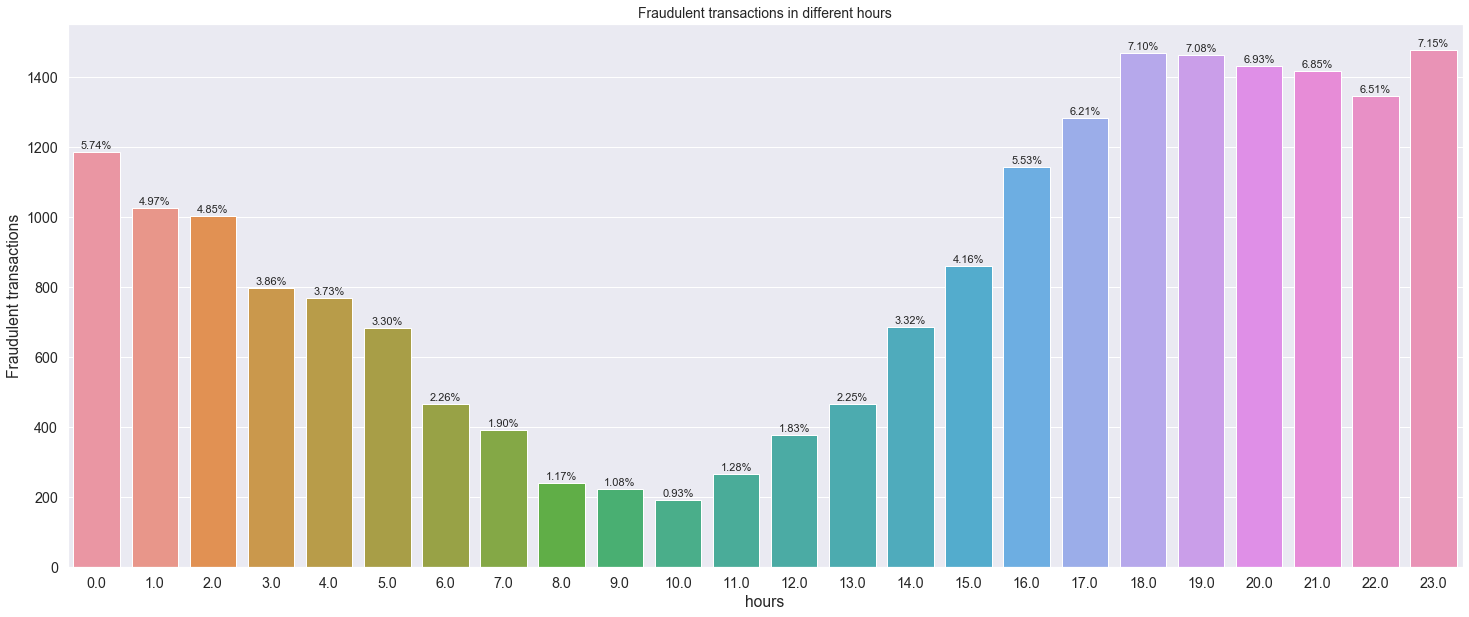

Total Frauds : 20663


In [30]:
total_frauds = Fraud_counts['isFraud'].sum()

plt.figure(figsize=(25, 10))
ax = sns.barplot(x=Fraud_counts.index, y=Fraud_counts['isFraud'], data=train_merged)
ax.set_title('Fraudulent transactions in different hours', fontsize=14)

for rectBox in ax.patches:
    count = rectBox.get_height()
    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 10,
            '{:1.2f}%'.format(count/total_frauds*100),
            ha="center", fontsize=11)

plt.ylabel('Fraudulent transactions')
plt.show()

# Lesser no. of fraudulent transactions between 0700 - 1200
print("Total Frauds :", total_frauds)

In [32]:
is_fraud.shape, len(is_fraud)

((20663, 435), 20663)

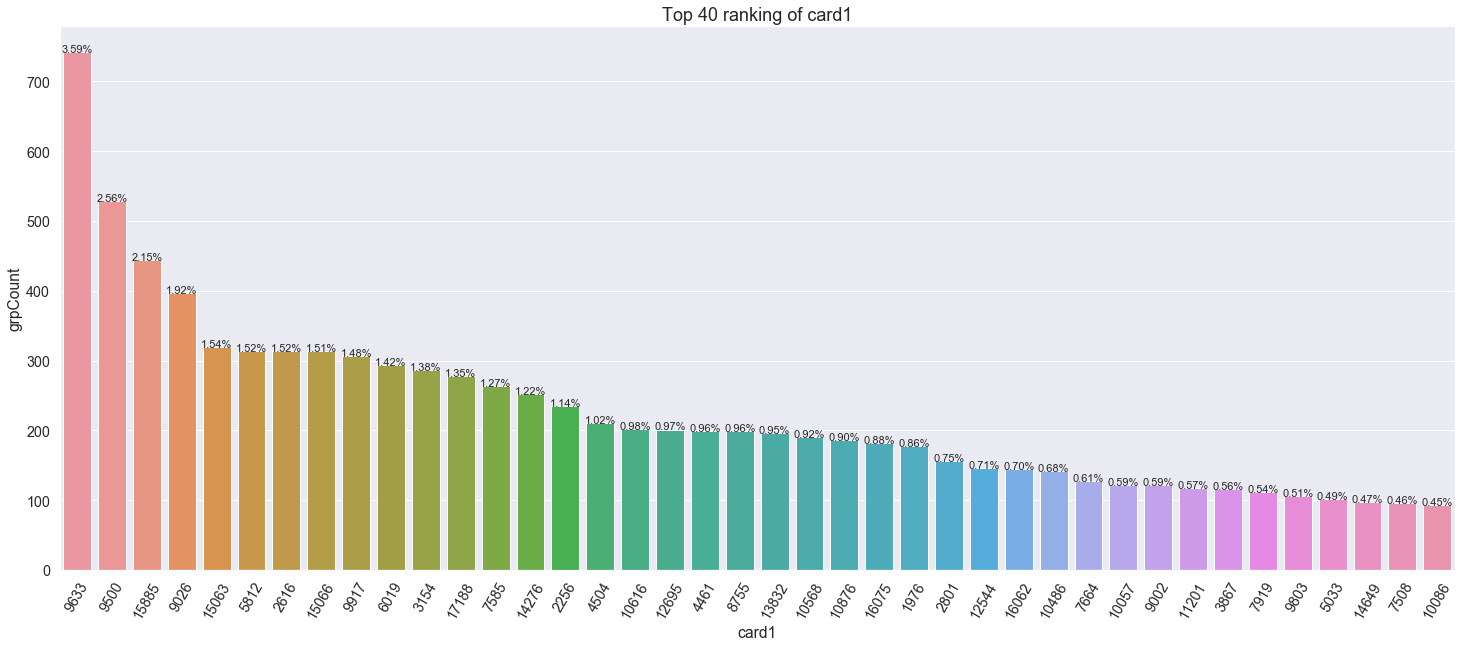

Total no. of card1 : 1740
Missing Data for card1 : 0.00%


In [33]:
# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='card1', total_items=len(is_fraud), display_topmost=40, text_padding=0.1)

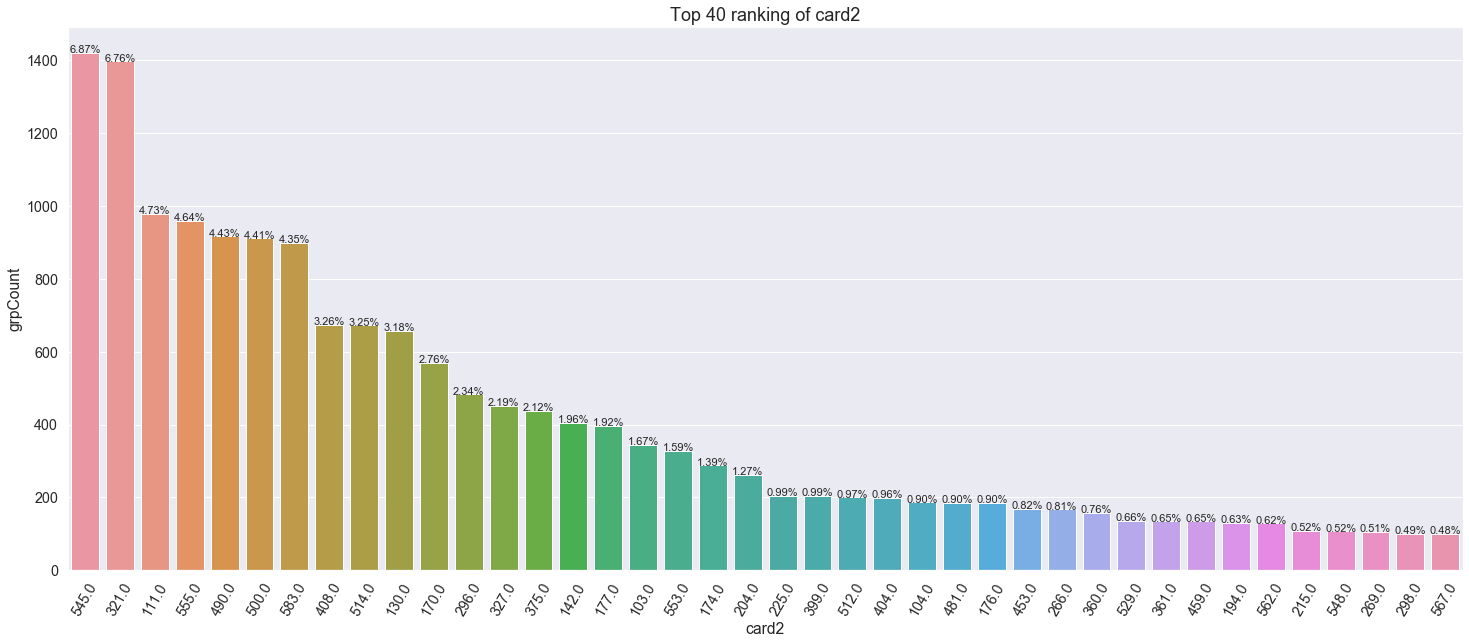

Total no. of card2 : 327
Missing Data for card2 : 2.05%


In [47]:
# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='card2', total_items=len(is_fraud), display_topmost=40, text_padding=0.1)

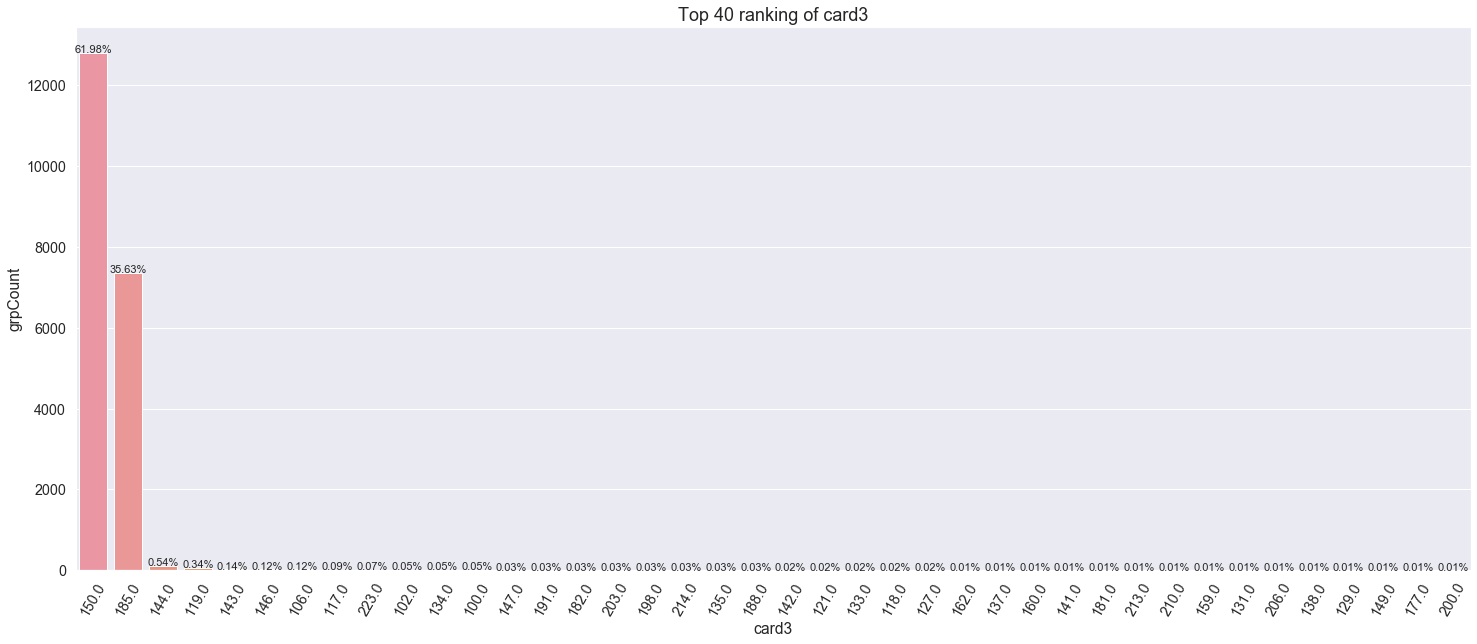

Total no. of card3 : 62
Missing Data for card3 : 0.19%


In [48]:
# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='card3', total_items=len(is_fraud), display_topmost=40, text_padding=0.1)

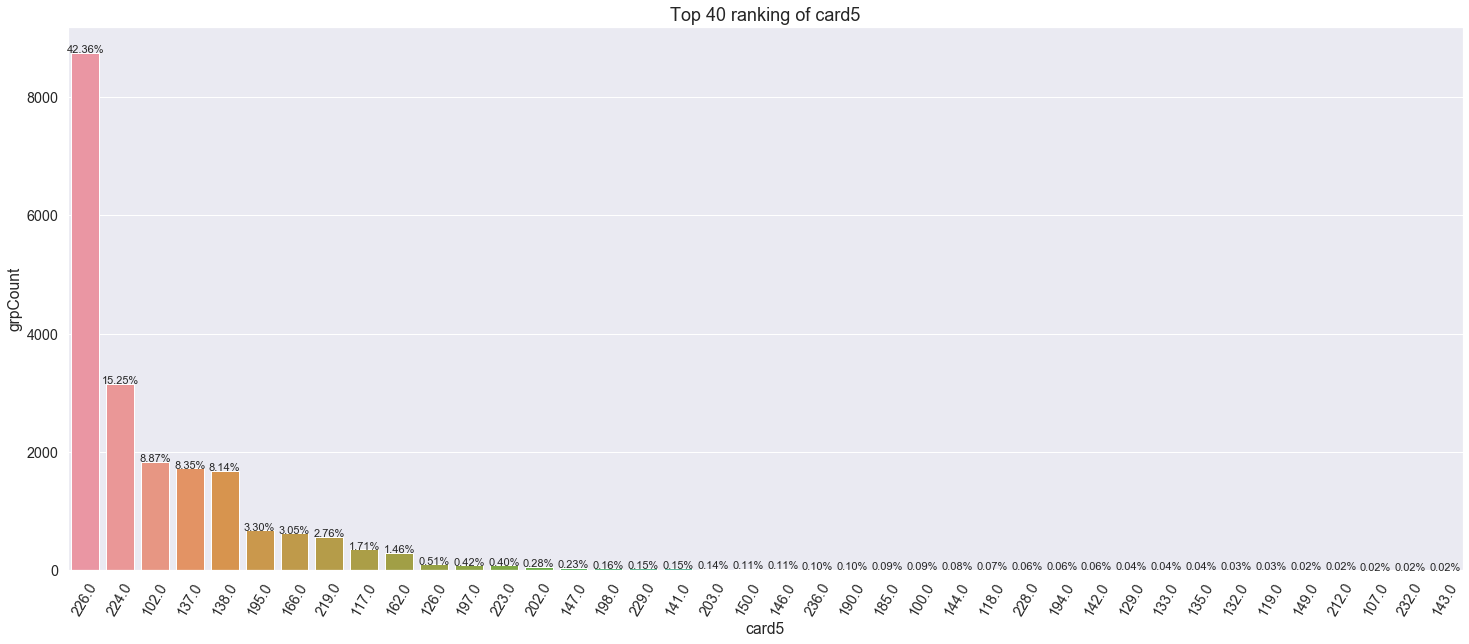

Total no. of card5 : 49
Missing Data for card5 : 1.02%


In [49]:
# Observe most common values for 'id_25'
# Categorical Features - Transaction
# 1. ProductCD
# 2. card1 - card6
# 3. addr1, addr2
# 4. P_emaildomain
# 5. R_emaildomain
# 6. M1 - M9

# Categorical Features - Identity
# 7. DeviceType
# 8. DeviceInfo
# 9. id_12 - id_38

# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='card5', total_items=len(is_fraud), display_topmost=40, text_padding=0.1)

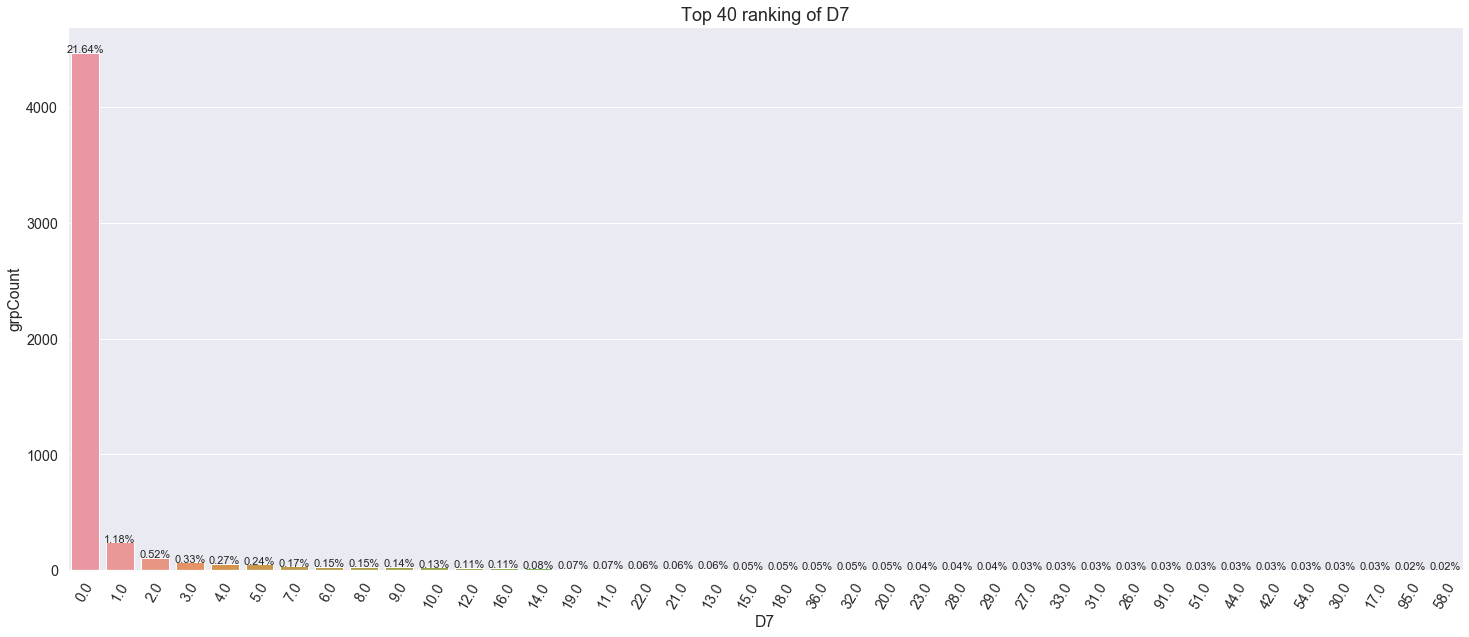

Total no. of D7 : 241
Missing Data for D7 : 71.98%


In [34]:
# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='D7', total_items=len(is_fraud), display_topmost=40, text_padding=0.1)

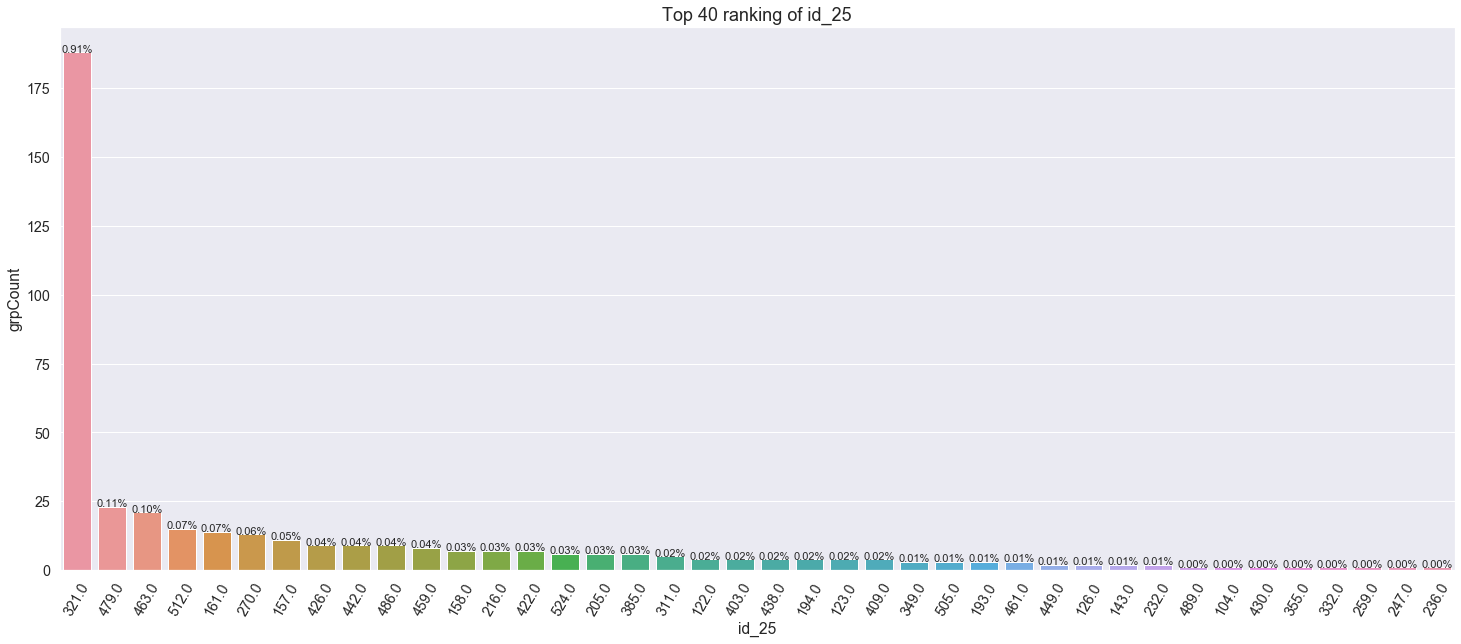

Total no. of id_25 : 41
Missing Data for id_25 : 97.98%


In [35]:
# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='id_25', total_items=len(is_fraud), display_topmost=40, text_padding=0.1)

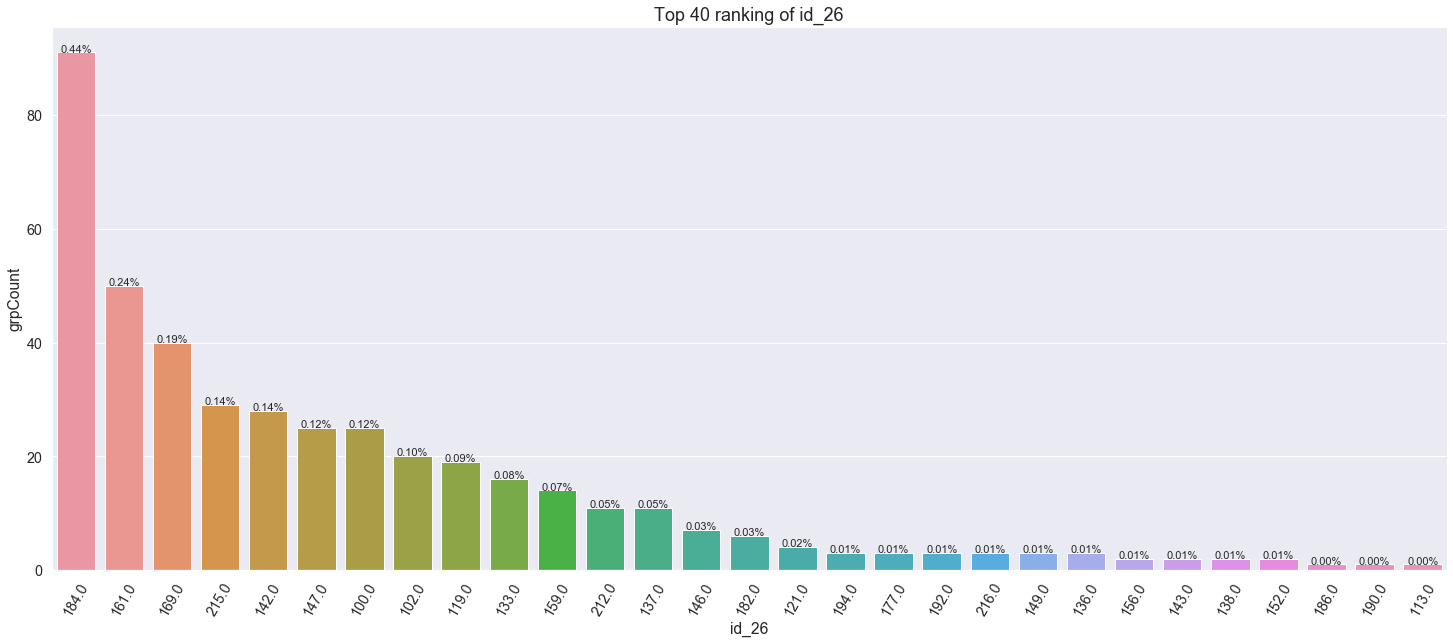

Total no. of id_26 : 29
Missing Data for id_26 : 97.94%


In [36]:
# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='id_26', total_items=len(is_fraud), display_topmost=40, text_padding=0.1)

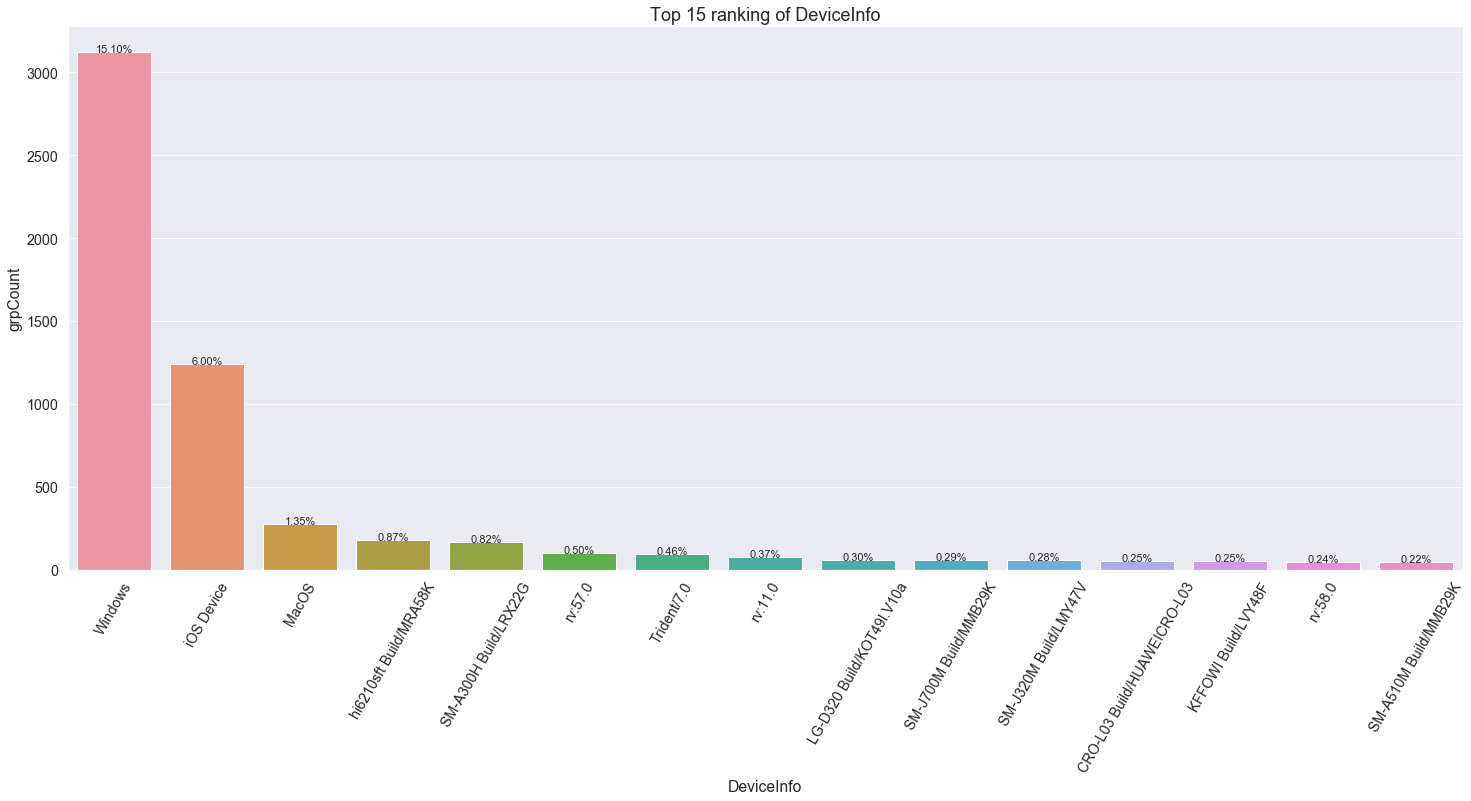

Total no. of DeviceInfo : 420
Missing Data for DeviceInfo : 58.35%


In [37]:
# Plot respective details
plot_topmost_parm(source_df=is_fraud, col_name='DeviceInfo', total_items=len(is_fraud), display_topmost=15, text_padding=0.1)

In [38]:
train_merged.shape # Added the features "weekday" and "hours" from "TransactionDT"

(590540, 435)

In [ ]:
imputer_list = ['D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'addr1',
                'addr2', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_26']

# id_12, id_15, id_28, id_29, id_31, id_35, id_36, id_37, id_38 are object types
train_merged[imputer_list].head(10)

# Need to examine id_12-38 and TransactionDT

In [ ]:
from sklearn.impute import SimpleImputer

# D11               47.29%
# D10               12.87%
# Imputation for missing values with mean values
mean_imputer = SimpleImputer()

X_transformed = pd.DataFrame(mean_imputer.fit_transform(pd.DataFrame(train_merged[imputer_list])).astype(int))

X_transformed.index = train_merged.index

train_merged[imputer_list].head(10)

In [ ]:
# Alternative transformation to produce mean values for each columns in the list
for col_name in imputer_list:
    tmp_pd = pd.DataFrame(mean_imputer.fit_transform(pd.DataFrame(train_merged[col_name])).astype(int))
    tmp_pd.index = train_merged.index
    train_merged[col_name] = tmp_pd

train_merged[imputer_list].head(10)

# Categorical Features - Transaction
1. ProductCD
2. card1 - card6
3. addr1, addr2
4. P_emaildomain
5. R_emaildomain
6. M1 - M9

# Categorical Features - Identity
7. DeviceType
8. DeviceInfo
9. id_12 - id_38<BR>
<BR>** The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). **

### <B>1. ProductCD</B>

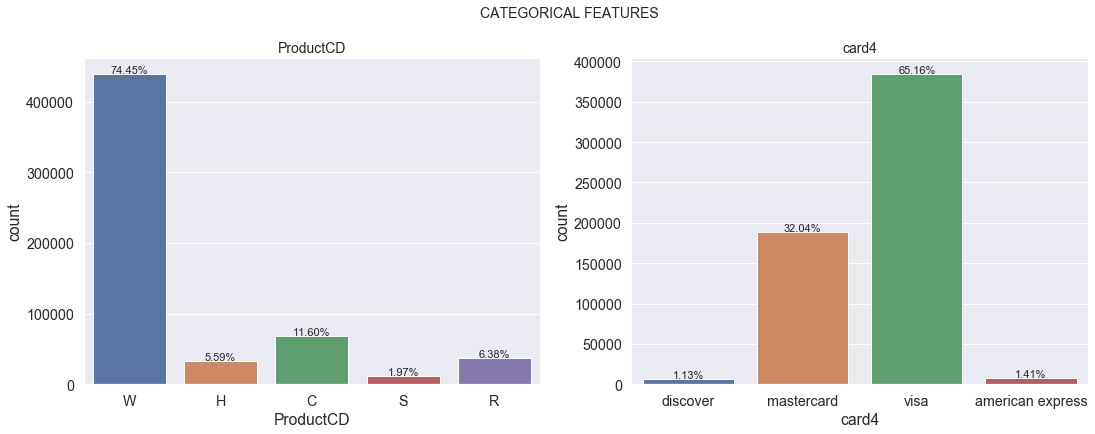

Missing Data for ProductCD :0.00%
Missing Data for card 3 :0.27%


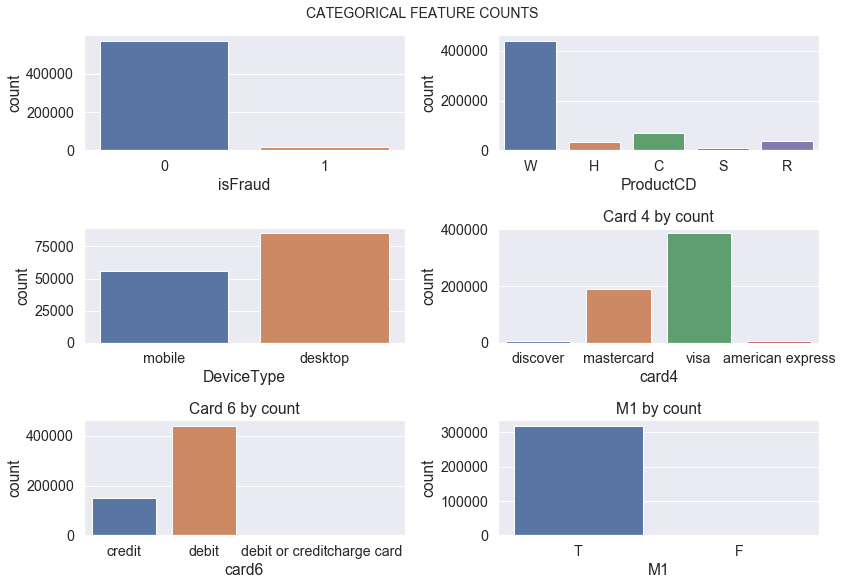

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle('Categorical Features'.upper(), y=1.0, fontsize=14)

df_dType = pd.DataFrame({'ProductCD' : train_merged['ProductCD']})
df_id12 = pd.DataFrame({'id_12' : train_merged['id_12']})
#df_dType['ProductCD'] = df_dType['ProductCD'].fillna(-999)

ProductCD = sns.countplot(x='ProductCD', data=df_dType, ax=axes[0])
ProductCD.set_title('ProductCD', fontsize=14)
for rectBox in ProductCD.patches:
    count = rectBox.get_height()
    #print("ProductCD Counts :", count)
    
    ProductCD.text(rectBox.get_x() + rectBox.get_width()/2.,
                   count + 1000,
                   '{:1.2f}%'.format(count/total_counts*100),
                   ha="center", fontsize=11)

#print("----------------------------------------")
Card4 = sns.countplot(x=train_merged['card4'], data=train_merged, ax=axes[1])
Card4.set_title('card4', fontsize=14)
for rectBox in Card4.patches:
    count = rectBox.get_height()
    #print("Card4 Counts :", count)
    
    Card4.text(rectBox.get_x() + rectBox.get_width()/2.,
               count + 1000,
               '{:1.2f}%'.format(count/total_counts*100),
               ha="center", fontsize=11)

# Eg. To change the x-labels
# plt.xticks(np.arange(3), ("Missing", "Yes", "No"))
plt.show()

print("Missing Data for ProductCD :" + '{:1.2f}%'.format(train_merged['ProductCD'].isnull().sum() / total_counts * 100))
print("Missing Data for card 3 :" + '{:1.2f}%'.format(train_merged['card3'].isnull().sum() / total_counts * 100))


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
fig.subplots_adjust(hspace=1.0)
fig.suptitle('Categorical Feature counts'.upper(), y=1.02, fontsize=14)

isFraud = sns.countplot(x=train_merged['isFraud'], data=train_merged, ax=axes[0][0])
ProductCD = sns.countplot(x=train_merged['ProductCD'], data=train_merged, ax=axes[0][1])
DeviceType = sns.countplot(x=train_merged['DeviceType'], data=train_merged, ax=axes[1][0])

card4 = sns.countplot(x=train_merged['card4'], data=train_merged,ax=axes[1][1]).set_title("Card 4 by count")
card6 = sns.countplot(x=train_merged['card6'], data=train_merged, ax=axes[2][0]).set_title("Card 6 by count")
m1 = sns.countplot(x=train_merged['M1'], data=train_merged, ax=axes[2][1]).set_title("M1 by count")

plt.tight_layout()

### <B>2. card4 and card6</B>
(Missing Data : 0.27%)

In [40]:
c_cols = [c for c in train_merged if c[0] == 'c']

# Example : train_merged['id_01'].value_counts()
for ctr in range(len(c_cols)):
    col_name = c_cols[ctr]
    df_unique = train_merged[col_name].nunique()
    df_unique_counts = train_merged[col_name].value_counts()
    print ("No. of unique values in", col_name, " :", df_unique)
    #print ("No. of counts per unique value in", col_name, " :\n", df_unique_counts)
    print("Missing Data : " + '{:1.2f}%'.format(train_merged[col_name].isnull().sum() / total_counts * 100))
    
train_merged[c_cols].head()

No. of unique values in card1  : 13553
Missing Data : 0.00%
No. of unique values in card2  : 500
Missing Data : 1.51%
No. of unique values in card3  : 114
Missing Data : 0.27%
No. of unique values in card4  : 4
Missing Data : 0.27%
No. of unique values in card5  : 119
Missing Data : 0.72%
No. of unique values in card6  : 4
Missing Data : 0.27%


,card1,card2,card3,card4,card5,card6
TransactionID,,,,,,
2987000,13926,NaN,150.0,discover,142.0,credit
2987001,2755,404.0,150.0,mastercard,102.0,credit
2987002,4663,490.0,150.0,visa,166.0,debit
2987003,18132,567.0,150.0,mastercard,117.0,debit
2987004,4497,514.0,150.0,mastercard,102.0,credit


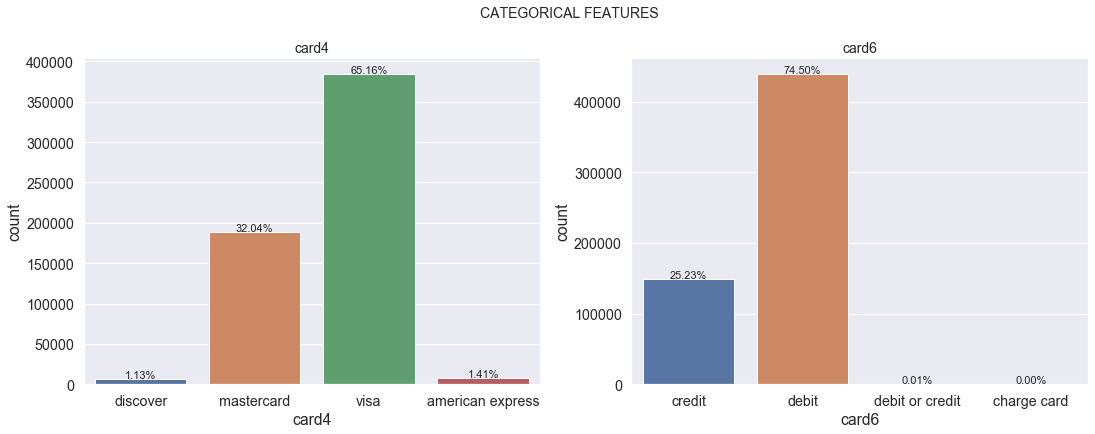

Missing Data for card 4 :0.27%
Missing Data for card 6 :0.27%


In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle('Categorical Features'.upper(), y=1.0, fontsize=14)
df_card4 = pd.DataFrame({'card4' : train_merged['card4']})
df_card6 = pd.DataFrame({'card4' : train_merged['card6']})

#df_dType['ProductCD'] = df_dType['ProductCD'].fillna(-999)

Card4 = sns.countplot(x=train_merged['card4'], data=train_merged, ax=axes[0])
Card4.set_title('card4', fontsize=14)
for rectBox in Card4.patches:
    count = rectBox.get_height()
    #print("Card4 Counts :", count)
    
    Card4.text(rectBox.get_x() + rectBox.get_width()/2.,
               count + 1000,
               '{:1.2f}%'.format(count/total_counts*100),
               ha="center", fontsize=11)

#print("----------------------------------------")
Card6 = sns.countplot(x=train_merged['card6'], data=train_merged, ax=axes[1])
Card6.set_title('card6', fontsize=14)
for rectBox in Card6.patches:
    count = rectBox.get_height()
    #print("Card6 Counts :", count)
    
    Card6.text(rectBox.get_x() + rectBox.get_width()/2.,
               count + 1000,
               '{:1.2f}%'.format(count/total_counts*100),
               ha="center", fontsize=11)

# Eg. To change the x-labels
# plt.xticks(np.arange(3), ("Missing", "Yes", "No"))
plt.show()

print("Missing Data for card 4 :" + '{:1.2f}%'.format(train_merged['card4'].isnull().sum() / total_counts * 100))
print("Missing Data for card 6 :" + '{:1.2f}%'.format(train_merged['card6'].isnull().sum() / total_counts * 100))

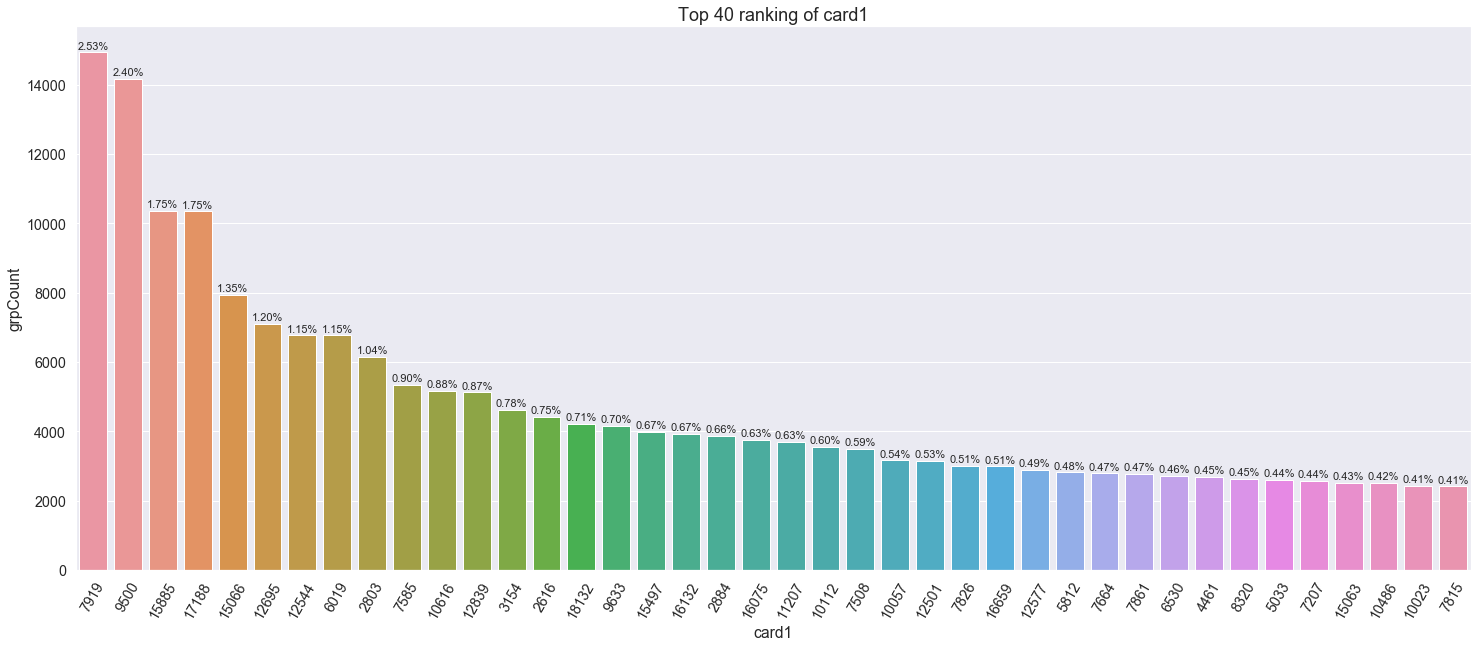

Total no. of card1 : 13553
Missing Data for card1 : 0.00%


In [50]:
# Plot card1 details
plot_topmost_parm(source_df=train_merged, col_name='card1', total_items=len(train_merged), display_topmost=40, text_padding=100)

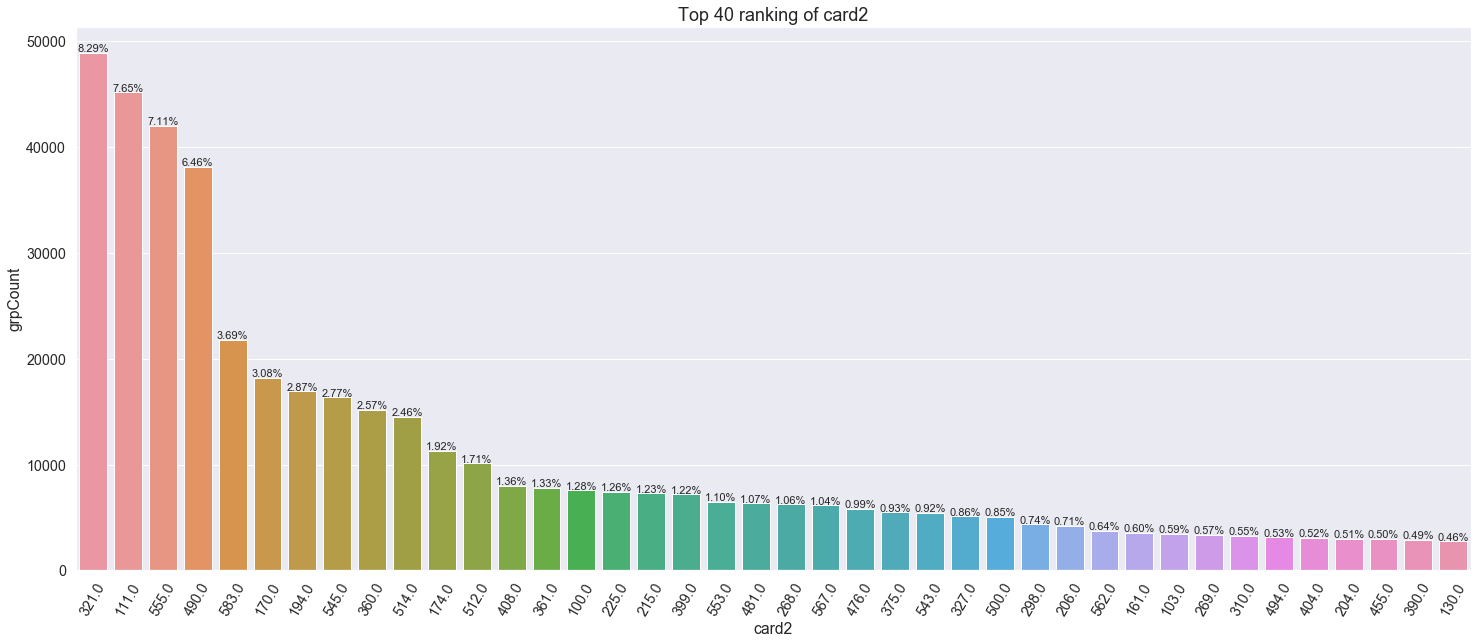

Total no. of card2 : 500
Missing Data for card2 : 1.51%


In [51]:
# Plot card2 details
plot_topmost_parm(source_df=train_merged, col_name='card2', total_items=len(train_merged), display_topmost=40, text_padding=100)

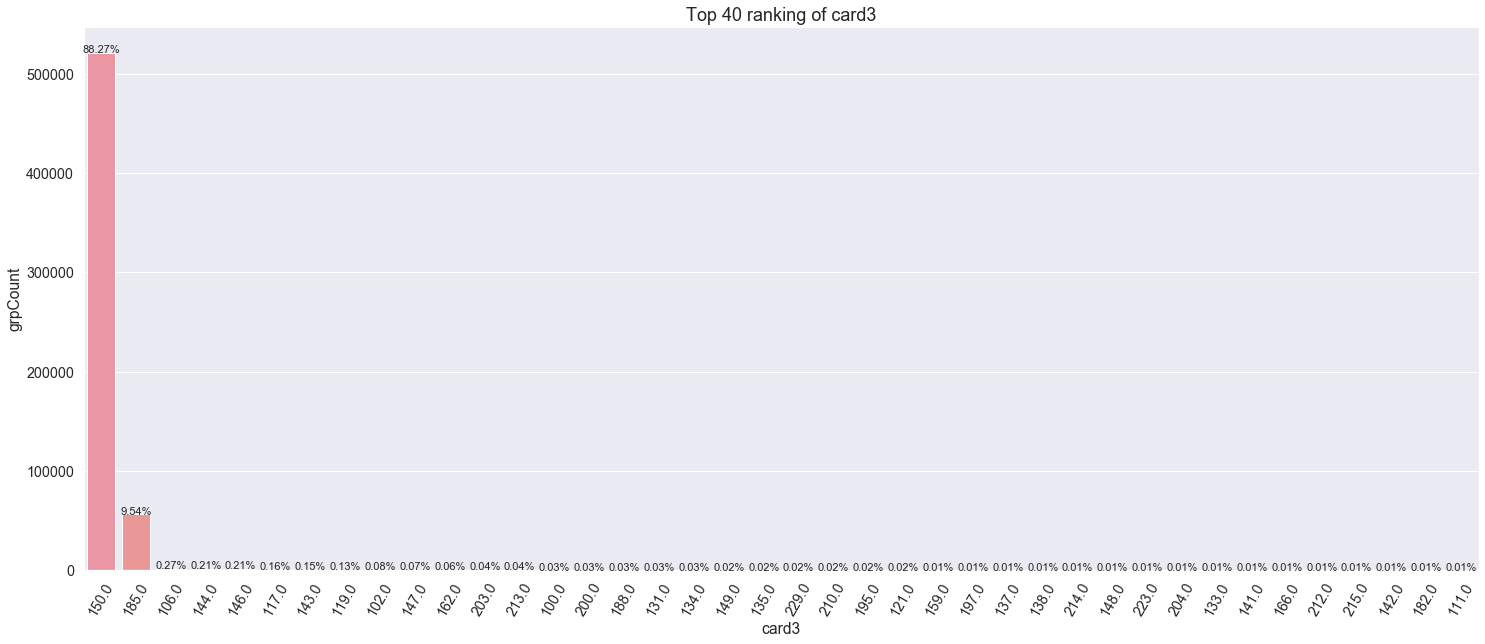

Total no. of card3 : 114
Missing Data for card3 : 0.27%


In [52]:
# Plot card3 details
plot_topmost_parm(source_df=train_merged, col_name='card3', total_items=len(train_merged), display_topmost=40, text_padding=100)

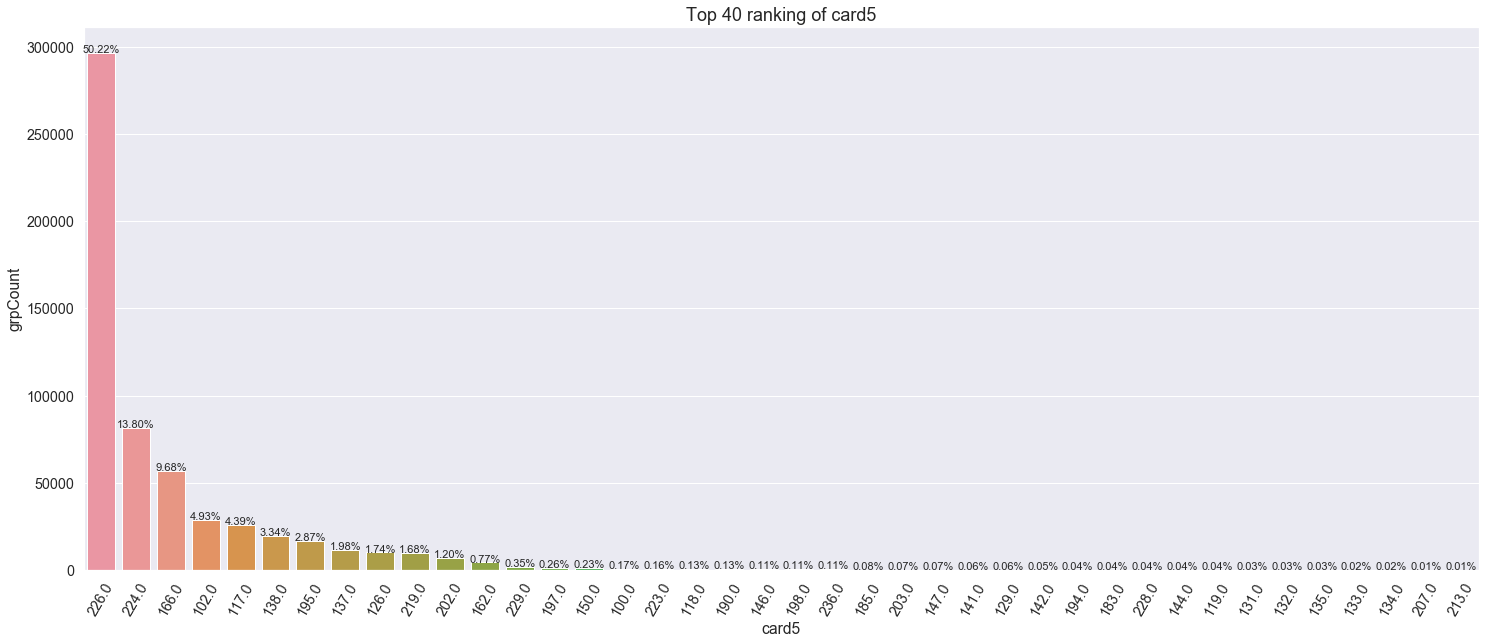

Total no. of card5 : 119
Missing Data for card5 : 0.72%


In [53]:
# Plot card5 details
plot_topmost_parm(source_df=train_merged, col_name='card5', total_items=len(train_merged), display_topmost=40, text_padding=100)

### <B>3. addr1 and addr2</B>

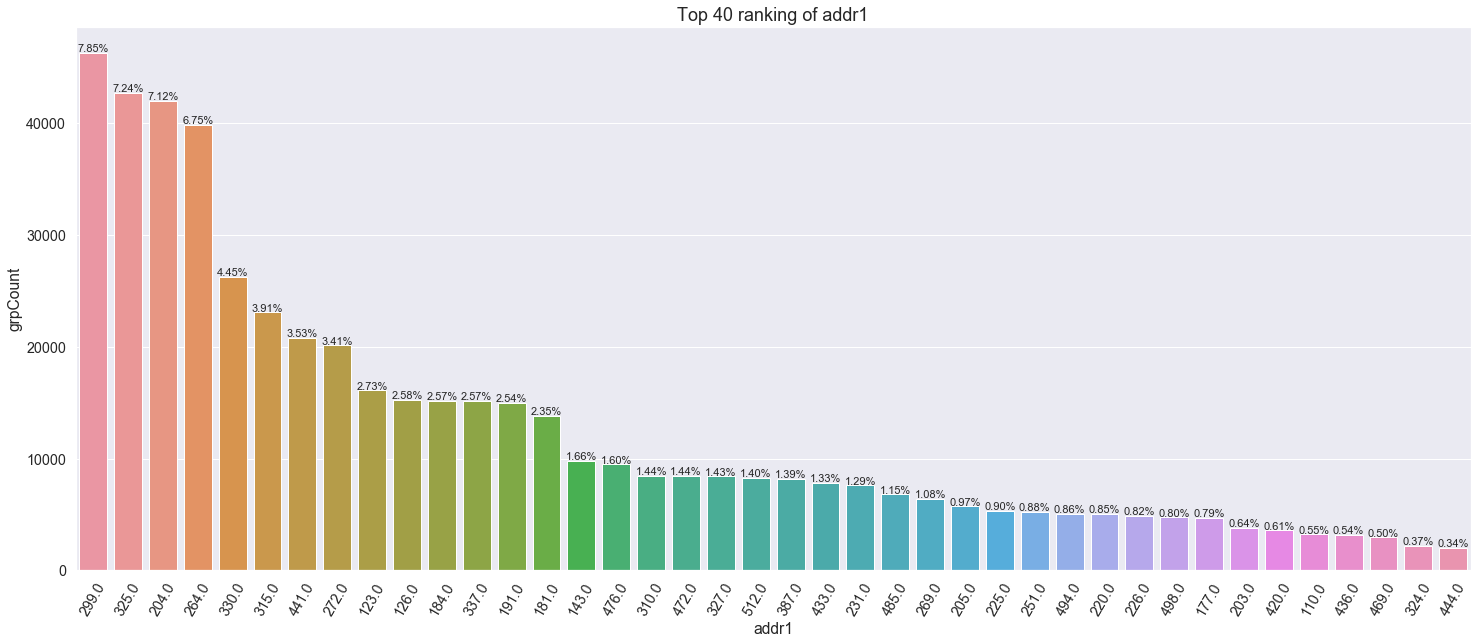

Total no. of addr1 : 332
Missing Data for addr1 : 11.13%


In [54]:
# Plot addr1 details
plot_topmost_parm(source_df=train_merged, col_name='addr1', total_items=len(train_merged), display_topmost=40, text_padding=100)

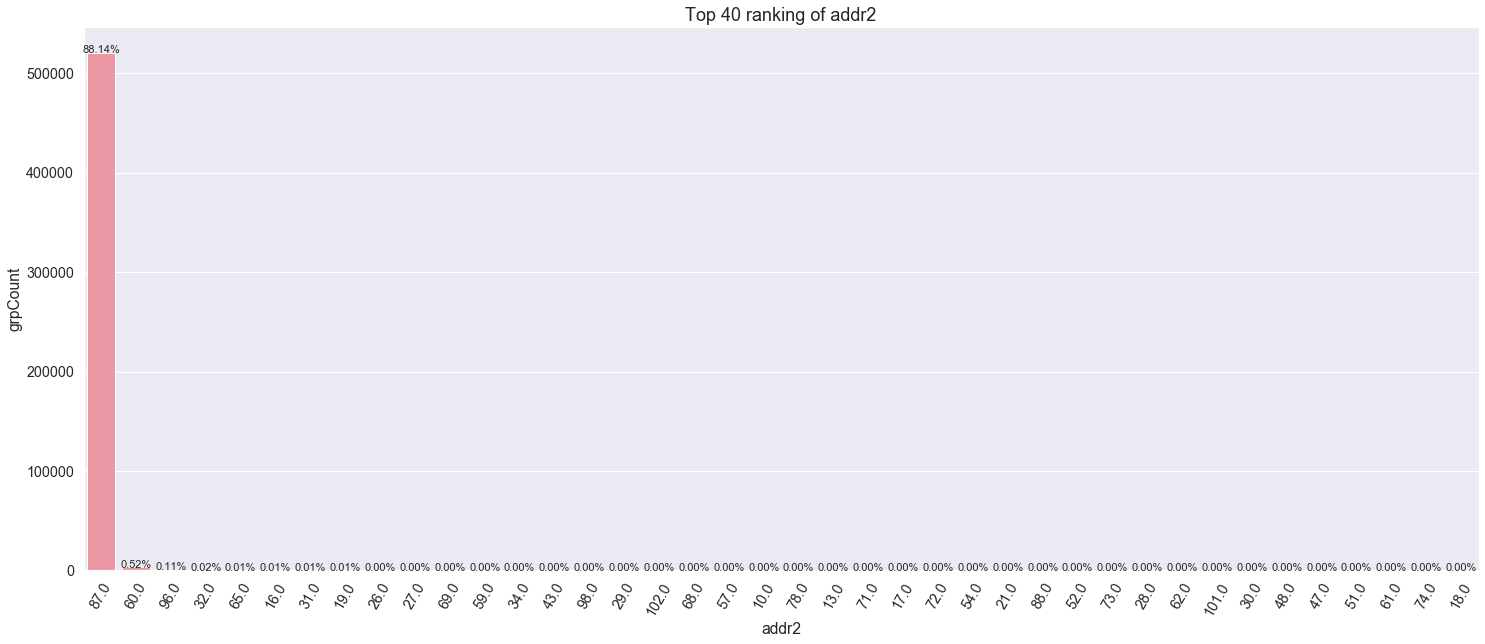

Total no. of addr2 : 74
Missing Data for addr2 : 11.13%


In [55]:
# Plot addr2 details
plot_topmost_parm(source_df=train_merged, col_name='addr2', total_items=len(train_merged), display_topmost=40, text_padding=100)

### <B>4. P_emaildomain</B>

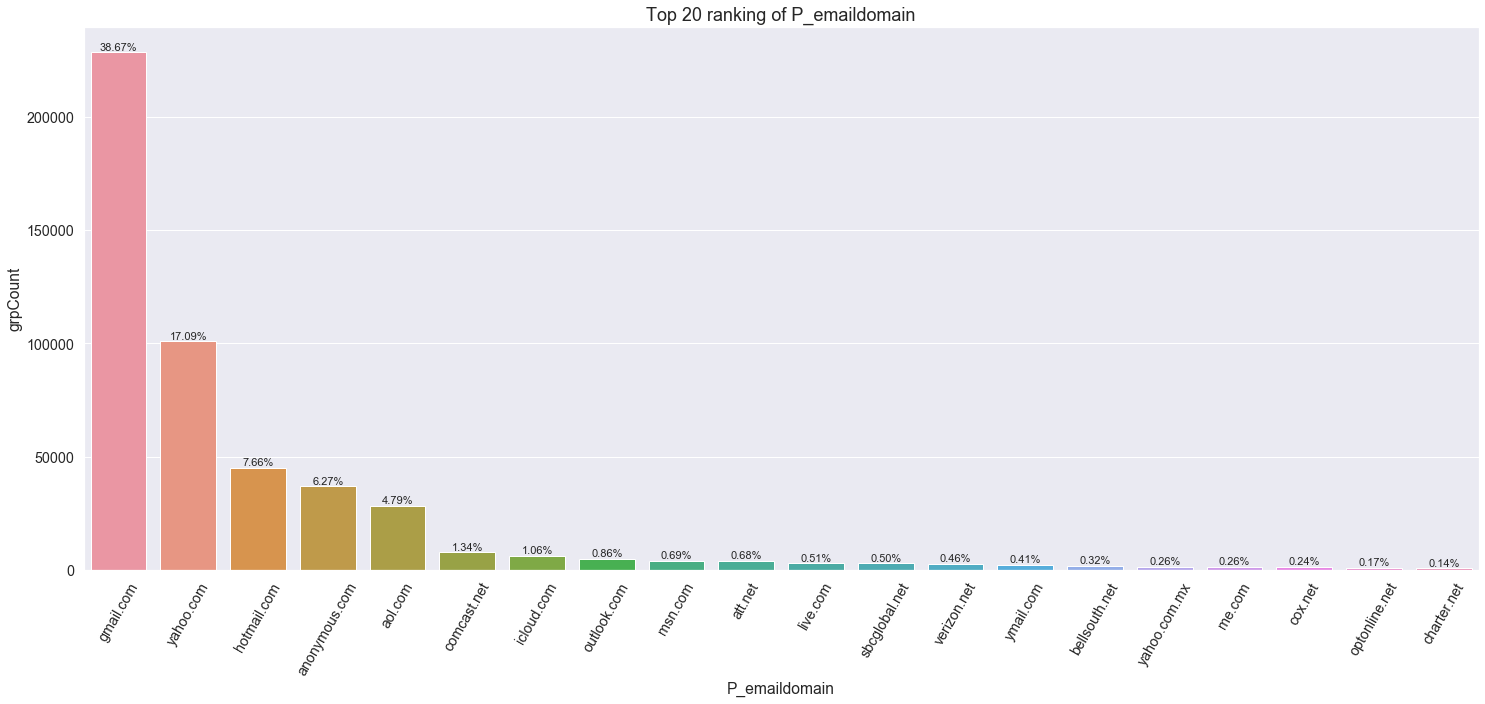

Total no. of P_emaildomain : 59
Missing Data for P_emaildomain : 15.99%


In [56]:
# Plot P_emaildomain details
plot_topmost_parm(source_df=train_merged, col_name='P_emaildomain', total_items=len(train_merged), display_topmost=20, text_padding=1000)

### <B>5. R_emaildomain</B>

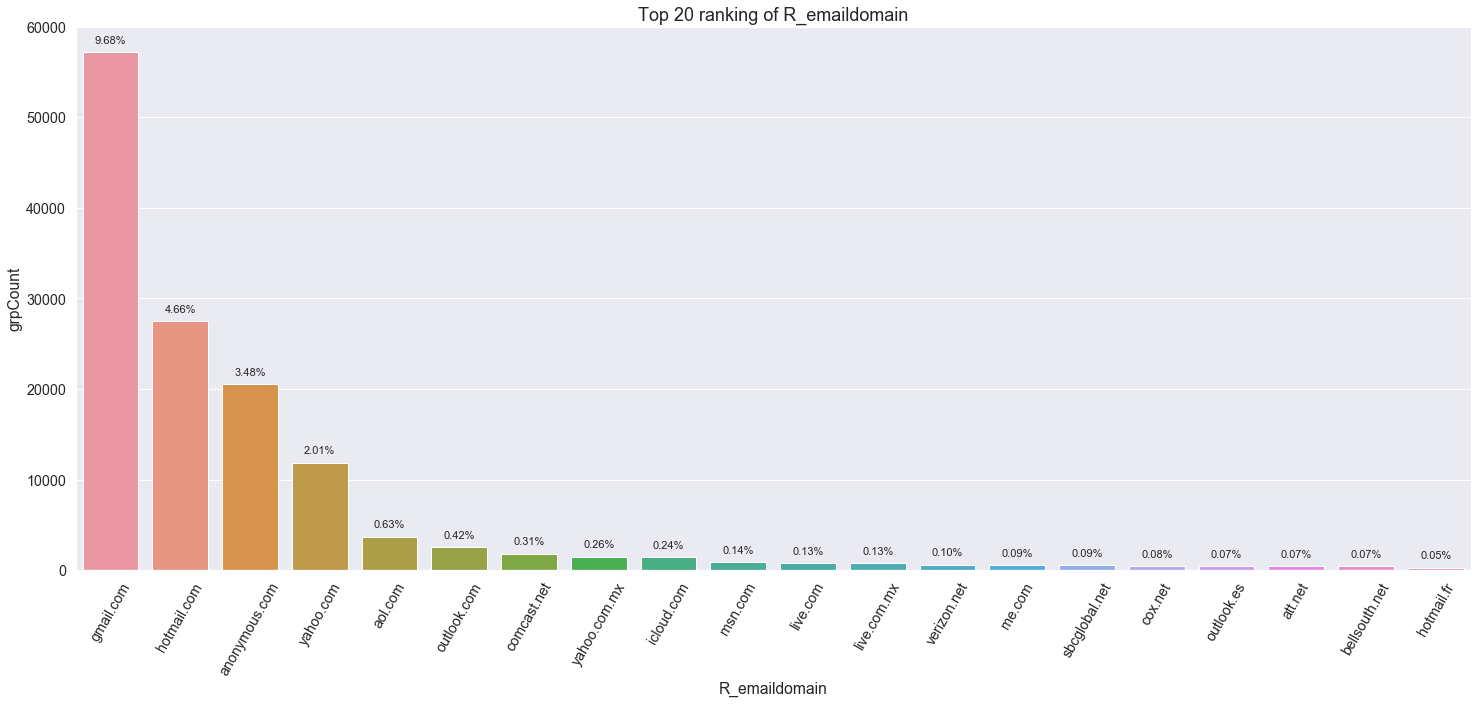

Total no. of R_emaildomain : 60
Missing Data for R_emaildomain : 76.75%


In [57]:
# Plot R_emaildomain details
plot_topmost_parm(source_df=train_merged, col_name='R_emaildomain', total_items=len(train_merged), display_topmost=20, text_padding=1000)

### <B>6. M1 - M9</B>

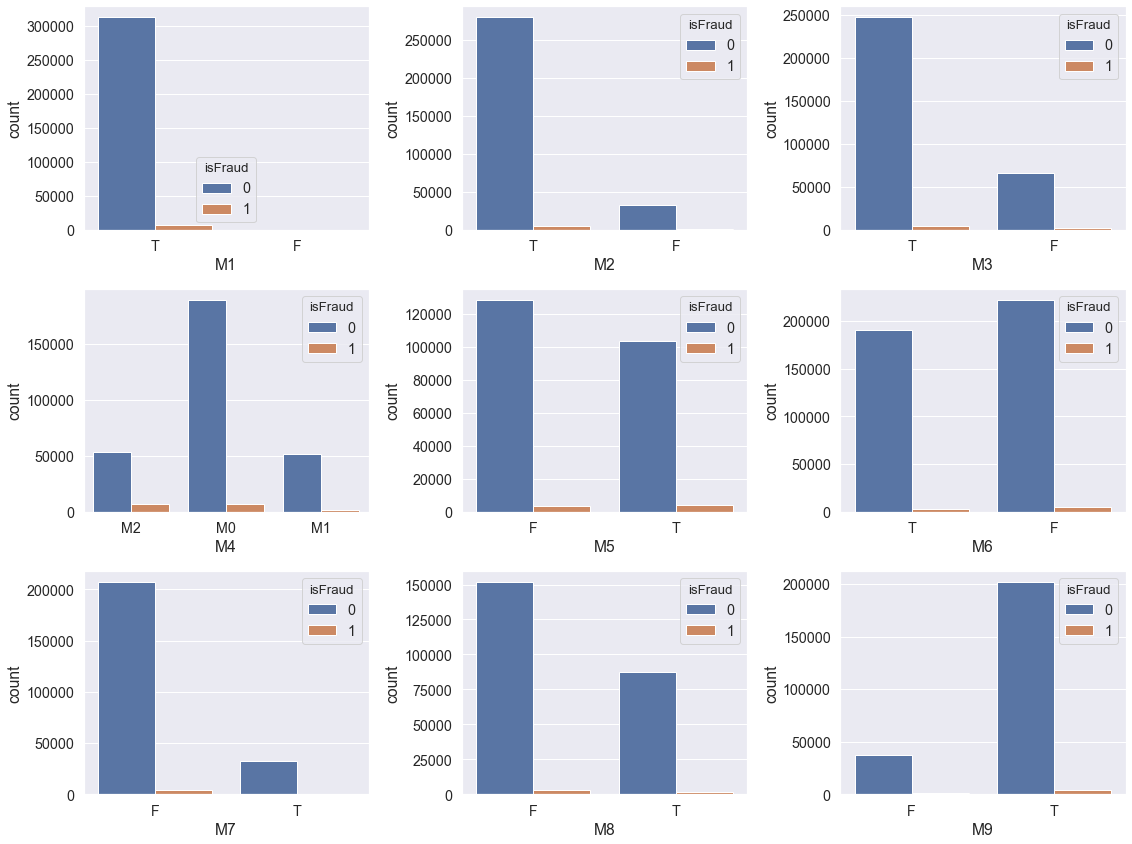

In [58]:
M1_loc = train_merged.columns.get_loc("M1")
M9_loc = train_merged.columns.get_loc("M9")
df_m = train_merged.iloc[:,M1_loc:M9_loc+1] #subset dataframe M1-M9
df_m['isFraud'] = train_merged.isFraud 

df_m_cols = df_m.columns
figure, axes = plt.subplots(3, 3, figsize=(16, 12))
count = 0
for i in range(3): # rows loop
    for j in range(3): # cols loop
        mplot = sns.countplot(x=df_m_cols[count], hue = 'isFraud', data=df_m, ax=axes[i,j])
        count += 1 # to loop over col-names
plt.tight_layout()

In [59]:
# df_m_cols.values gives ['M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'isFraud']
for ctr in range(len(df_m_cols.values)):
    col_name = df_m_cols[ctr]
    df_m1_unique = df_m[col_name].nunique()
    df_m1_unique_counts = df_m[col_name].value_counts()
    print ("No. of unique values in", col_name, " :", df_m1_unique)
    print ("No. of counts per unique value in ", col_name, " :\n", df_m1_unique_counts)
    print("Missing Data for", col_name + " : " +
          '{:1.2f}%'.format(train_merged[col_name].isnull().sum() / total_counts * 100))
    print("----------------------------------------")

No. of unique values in M1  : 2
No. of counts per unique value in  M1  :
 T    319415
F        25
Name: M1, dtype: int64
Missing Data for M1 : 45.91%
----------------------------------------
No. of unique values in M2  : 2
No. of counts per unique value in  M2  :
 T    285468
F     33972
Name: M2, dtype: int64
Missing Data for M2 : 45.91%
----------------------------------------
No. of unique values in M3  : 2
No. of counts per unique value in  M3  :
 T    251731
F     67709
Name: M3, dtype: int64
Missing Data for M3 : 45.91%
----------------------------------------
No. of unique values in M4  : 3
No. of counts per unique value in  M4  :
 M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64
Missing Data for M4 : 47.66%
----------------------------------------
No. of unique values in M5  : 2
No. of counts per unique value in  M5  :
 F    132491
T    107567
Name: M5, dtype: int64
Missing Data for M5 : 59.35%
----------------------------------------
No. of unique values in M6  : 

### <B>7. DeviceType</B>

Counts : 449730
Counts : 55645
Counts : 85165


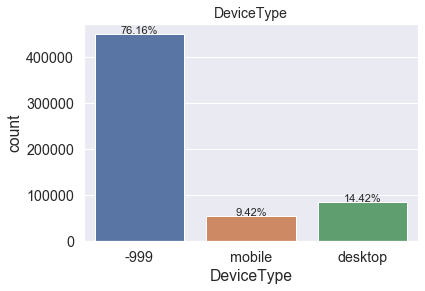

Missing Data : 76.16%


In [60]:
df_dType = pd.DataFrame({'DeviceType' : train_merged['DeviceType']})
df_dType['DeviceType'] = df_dType['DeviceType'].fillna(-999)

ax = sns.countplot(x='DeviceType', data=df_dType)
ax.set_title('DeviceType', fontsize=14)
for rectBox in ax.patches:
    count = rectBox.get_height()
    print("Counts :", count)
    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=11)

# Change the x-labels
#plt.xticks(np.arange(3), ("Missing", "Yes", "No"))
plt.show()

print("Missing Data : " + '{:1.2f}%'.format(train_merged['DeviceType'].isnull().sum() / total_counts * 100))

### <B>8. DeviceInfo</B>

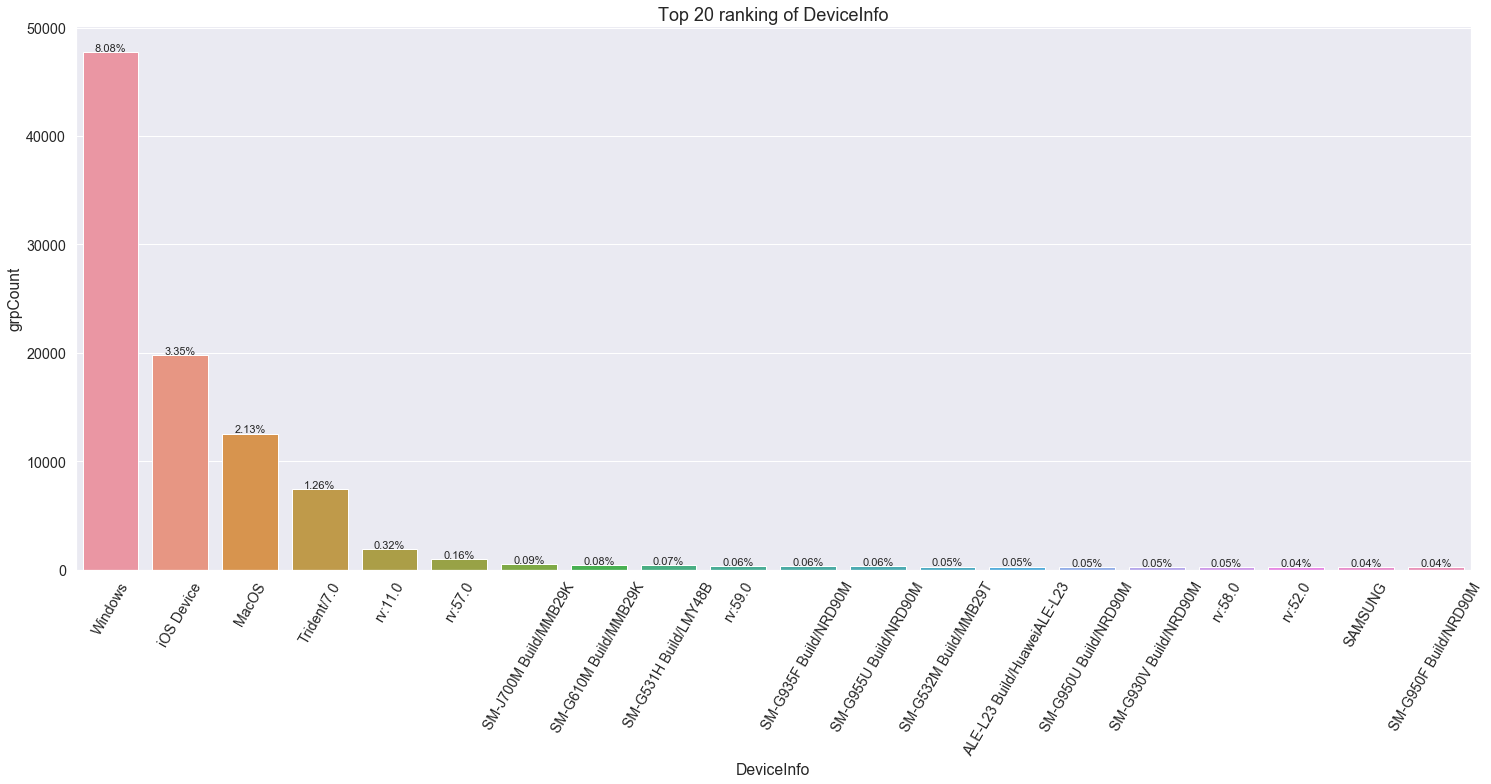

Total no. of DeviceInfo : 1786
Missing Data for DeviceInfo : 79.91%


In [61]:
# Plot DeviceInfo details
plot_topmost_parm(source_df=train_merged, col_name='DeviceInfo', total_items=len(train_merged), display_topmost=20, text_padding=100)

### <B>9. Id_01 - 38</B>

In [62]:
id_ctr = list(range(12, 39)) # Range from 12 - 38
id_list = []
for num in id_ctr:
    numStr = "id_" + str(num) 
    id_list.append(numStr)

print(id_list)

for identifier in id_list:
    df = pd.DataFrame(train_merged[identifier], index = train_merged.index) # TransactionID is the index
    # Getting the unqiue values
    df = df.nunique()
    #print (df)

['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [63]:
# Initialized variables
total_counts = len(train_merged)

i_cols = [c for c in train_merged if c[0] == 'i']

# Example : train_merged['id_01'].value_counts()
for ctr in range(len(i_cols)):
    col_name = i_cols[ctr]
    df_unique = train_merged[col_name].nunique()
    df_unique_counts = train_merged[col_name].value_counts()
    print ("No. of unique values in", col_name, " :", df_unique)
    #print ("No. of counts per unique value in", col_name, " :\n", df_unique_counts)
    print("Missing Data : " + '{:1.2f}%'.format(train_merged[col_name].isnull().sum() / total_counts * 100))
    
train_merged[i_cols].head()

No. of unique values in isFraud  : 2
Missing Data : 0.00%
No. of unique values in id_01  : 77
Missing Data : 75.58%
No. of unique values in id_02  : 115655
Missing Data : 76.15%
No. of unique values in id_03  : 24
Missing Data : 88.77%
No. of unique values in id_04  : 15
Missing Data : 88.77%
No. of unique values in id_05  : 93
Missing Data : 76.82%
No. of unique values in id_06  : 101
Missing Data : 76.82%
No. of unique values in id_07  : 84
Missing Data : 99.13%
No. of unique values in id_08  : 94
Missing Data : 99.13%
No. of unique values in id_09  : 46
Missing Data : 87.31%
No. of unique values in id_10  : 62
Missing Data : 87.31%
No. of unique values in id_11  : 365
Missing Data : 76.13%
No. of unique values in id_12  : 2
Missing Data : 75.58%
No. of unique values in id_13  : 54
Missing Data : 78.44%
No. of unique values in id_14  : 25
Missing Data : 86.45%
No. of unique values in id_15  : 3
Missing Data : 76.13%
No. of unique values in id_16  : 2
Missing Data : 78.10%
No. of uniq

,isFraud,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


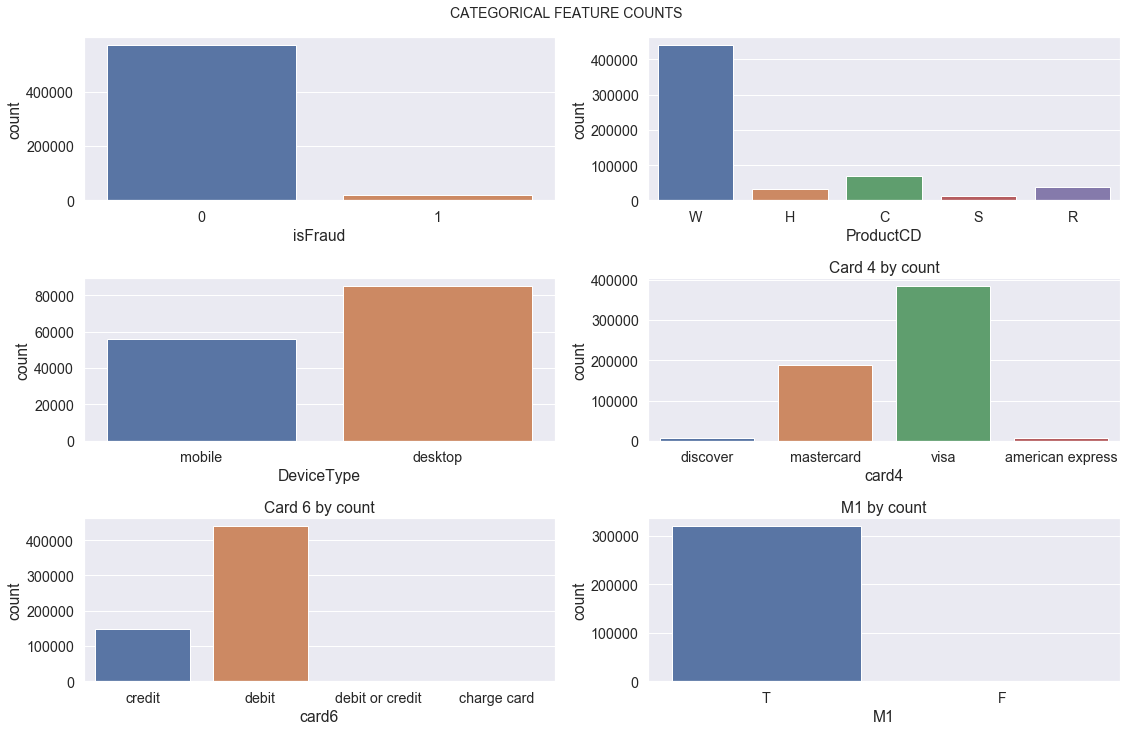

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
fig.subplots_adjust(hspace=1.0)
fig.suptitle('Categorical Feature counts'.upper(), y=1.02, fontsize=14)

isFraud = sns.countplot(x=train_merged['isFraud'], data=train_merged, ax=axes[0][0])
ProductCD = sns.countplot(x=train_merged['ProductCD'], data=train_merged, ax=axes[0][1])
DeviceType = sns.countplot(x=train_merged['DeviceType'], data=train_merged, ax=axes[1][0])
card4 = sns.countplot(x=train_merged['card4'], data=train_merged, ax=axes[1][1]).set_title("Card 4 by count")
card6 = sns.countplot(x=train_merged['card6'], data=train_merged, ax=axes[2][0]).set_title("Card 6 by count")
m1 = sns.countplot(x=train_merged['M1'], data=train_merged, ax=axes[2][1]).set_title("M1 by count")

plt.tight_layout()

# Inspecting Parameters is Fraud instances

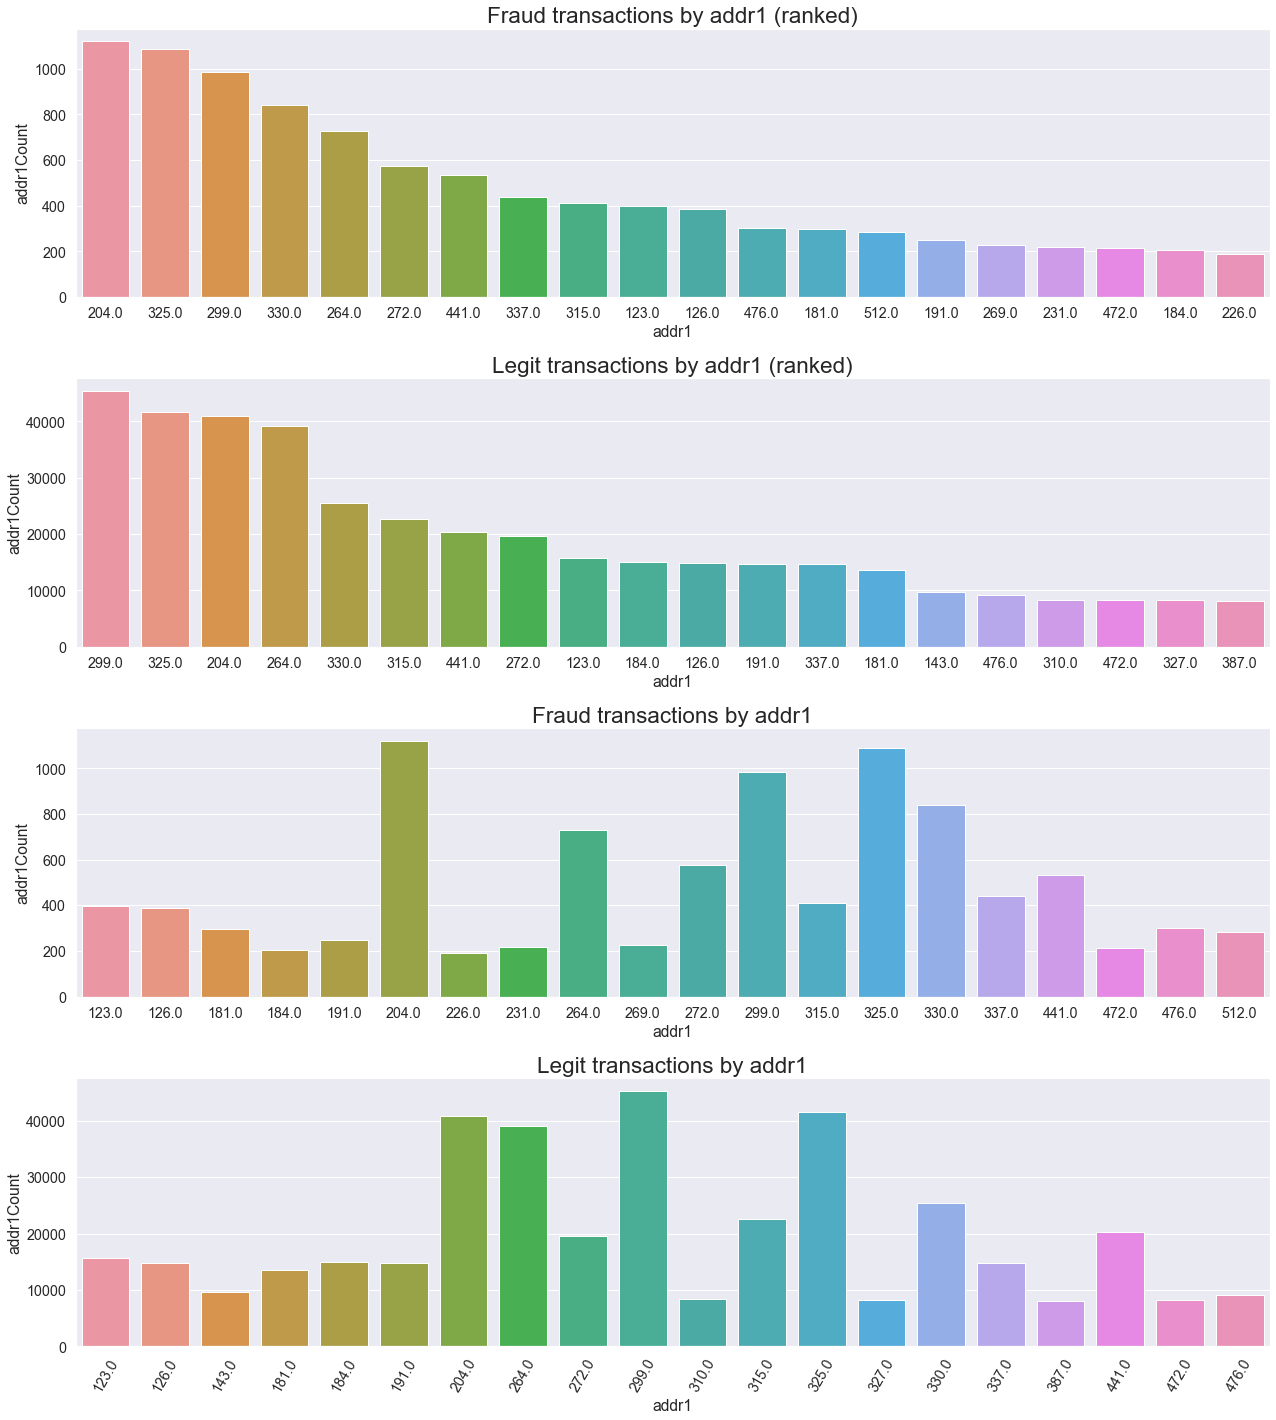

In [65]:
# Subset fraud dataset
addr = 'addr1'
addrC = 'addr1Count'
fraud = pd.DataFrame()
is_fraud = train_merged[train_merged['isFraud']==1]

fraud[addrC] = is_fraud.groupby([addr])[addr].count()
fraud[addr] = fraud.index

# Subset NOT fraud dataset
NOfraud = pd.DataFrame()
no_fraud = train_merged[train_merged['isFraud']==0]
NOfraud[addrC] = no_fraud.groupby([addr])[addr].count()
NOfraud[addr] = NOfraud.index

# There are too many addr, so we will subset the top 20
group_top_f = fraud.sort_values(by=addrC,ascending=False).head(20)
order_f = group_top_f.sort_values(by=addrC,ascending=False)[addr]

group_top_l = NOfraud.sort_values(by=addrC,ascending=False).head(20)
order_l = group_top_l.sort_values(by=addrC,ascending=False)[addr]

f, axes = plt.subplots(4, 1, figsize=(18, 20))

sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x=addr, y=addrC, data=group_top_f, order = order_f, ax=axes[0])
bx = sns.barplot(x=addr, y=addrC, data=group_top_l, order = order_l, ax=axes[1])

az = sns.barplot(x=addr, y=addrC, data=group_top_f, ax=axes[2])
bz = sns.barplot(x=addr, y=addrC, data=group_top_l, ax=axes[3])

font_size= {'size': 'x-large'}
ax.set_title("Fraud transactions by addr1 (ranked)", **font_size)
bx.set_title("Legit transactions by addr1 (ranked)", **font_size)

az.set_title("Fraud transactions by addr1", **font_size)
bz.set_title("Legit transactions by addr1", **font_size)

xt = plt.xticks(rotation=60)
plt.tight_layout()

In [66]:
print("No. of Frauds :", is_fraud.shape)
print("No. of Non-Frauds :", no_fraud.shape)

No. of Frauds : (20663, 435)
No. of Non-Frauds : (569877, 435)


In [67]:
is_fraud.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday,hours
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,...,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,0.0,1.0
2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,credit,...,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,0.0,1.0
2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,credit,...,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,0.0,1.0
2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,credit,...,NaN,NaN,F,F,F,F,mobile,NaN,0.0,1.0


In [68]:
is_fraud.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo', 'weekday', 'hours'],
      dtype='object', length=435)

In [69]:
total_num_fraud_features = len(is_fraud.columns)
print ("\nTotal no. of fraud features :", total_num_fraud_features)

fraud_unique_df = pd.DataFrame()
#fraud_unique_df.columns = is_fraud.columns

# Alternative transformation to produce mean values for each columns in the list
for col_name in is_fraud.columns:
    df_unique = is_fraud[col_name].nunique()
    df_unique_counts = is_fraud[col_name].value_counts()
    fraud_unique_df[col_name] = [df_unique] # Needs to have brackets to add values
    #print("No. of unique values in fraud feature", col_name, " :", df_unique)
    #print("No. of counts per unique value in", col_name, " :\n", df_unique_counts)
    #print("Missing Data : " + '{:1.2f}%'.format(is_fraud[col_name].isnull().sum() / total_frauds * 100))


Total no. of fraud features : 435


In [70]:
fraud_unique_df

# Details
#for ctr in range(len(fraud_unique_df.columns)):
#    col_name = fraud_unique_df.columns[ctr]
#    col_value = fraud_unique_df.iloc[0, ctr]
#    print(col_name + " :", col_value)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday,hours
0,1,20638,2515,5,1740,327,62,4,49,2,...,59,3,2,2,2,2,2,420,7,24


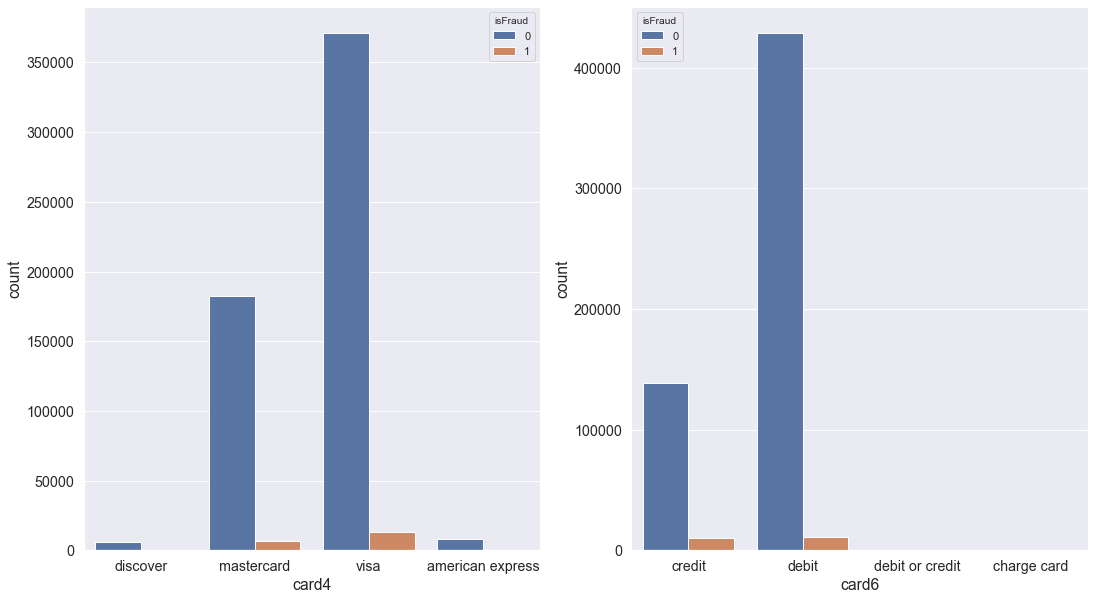

In [71]:
f, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.set(color_codes=True)
card4 = sns.countplot(x='card4', hue="isFraud", data=train_merged, ax=axes[0])
card6 = sns.countplot(x='card6', hue="isFraud", data=train_merged, ax=axes[1])

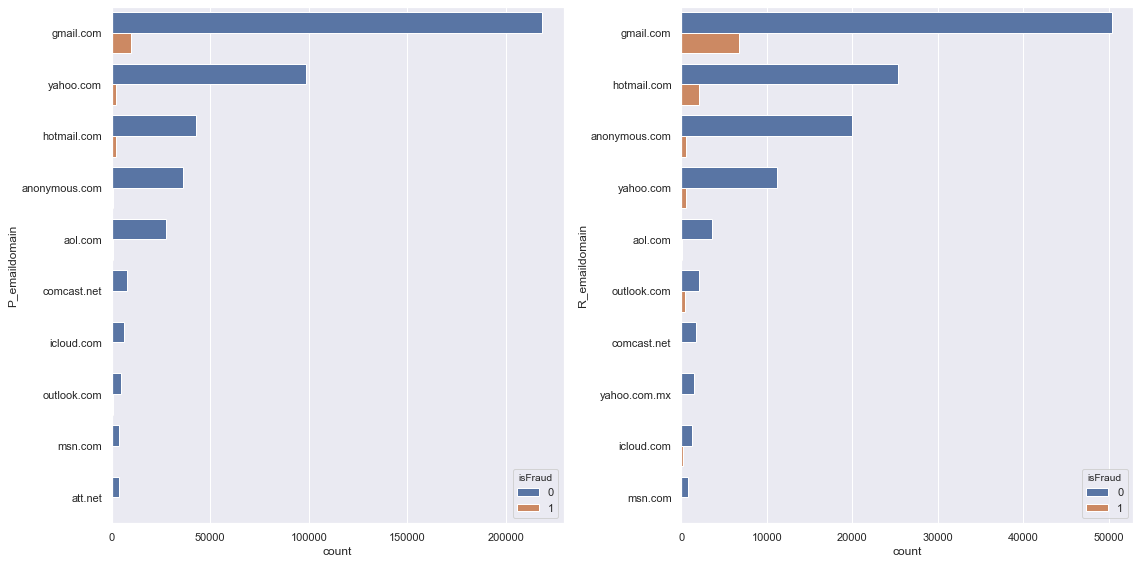

In [72]:
# Get top 10 
order_p=train_merged.P_emaildomain.value_counts().iloc[:10].index
order_r=train_merged.R_emaildomain.value_counts().iloc[:10].index

f, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.set(color_codes=True)
p_email = sns.countplot(y='P_emaildomain',  hue="isFraud", data=train_merged, order = order_p, ax=axes[0])
r_email = sns.countplot(y='R_emaildomain',  hue="isFraud", data=train_merged, order = order_r, ax=axes[1])
plt.tight_layout()

In [73]:
# Getting columns that starts with 'C'
c_cols = [c for c in train_merged if c[0] == 'C']
train_merged[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,
2987000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
2987001,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2987002,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2987003,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
2987004,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [74]:
df = pd.DataFrame(train_merged[c_cols], index = train_merged.index)

#df.C1.unique()
#output = df.drop_duplicates()
#output.groupby('C1').size()

# Getting the unqiue values
df = df.nunique() #.value_counts()

print (df)

C1     1657
C2     1216
C3       27
C4     1260
C5      319
C6     1328
C7     1103
C8     1253
C9      205
C10    1231
C11    1476
C12    1199
C13    1597
C14    1108
dtype: int64


In [75]:
d_cols = [c for c in train_merged if c[0] == 'D']
train_merged[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,
2987000,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,NaN,NaN
2987001,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2987002,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,NaN,NaN
2987003,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN
2987004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [76]:
m_cols = [c for c in train_merged if c[0] == 'M']
train_merged[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
v_cols = [c for c in train_merged if c[0] == 'V']
train_merged[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
T_cols = [c for c in train_merged if c[0] == 'T']
train_merged[T_cols].head()

,TransactionDT,TransactionAmt
TransactionID,,
2987000,86400,68.5
2987001,86401,29.0
2987002,86469,59.0
2987003,86499,50.0
2987004,86506,50.0


In [ ]:
# Obtained from missing_data_pc list
#[id_24...id_22]: 99.20%
# dist2         : 93.63%
# D7            : 93.41%
# id_18         : 92.36%
# D13           : 89.51%
# D14           : 89.47%
# D12           : 89.04%

#[id_04, id_03] : 88.77%
# [D6...id_09]  : 87.31%

#[id_30...id_14]: 86.87%
# [V151...V148] : 86.12%
# [V338...V337] : 86.05%

# [id_13,id_16] : 78.44%
# [V254, V269]  : 77.91%
# [id_05, id_06]: 76.82%
# R_emaildomain : 76.75%
#[id_20...id_17]: 76.42%

# [V167...V216] : 76.36%
# [V174...V189] : 76.32%
# [id_31, id_02]: 76.25%
#[id_29...id_38]: 76.13%
# [V221... V250]: 76.05%

# [id_01,id_12] : 75.58%
# dist1         : 59.65%
# M5            : 59.35%
# [M7 - M9]     : 58.64%
# D5            : 52.47%
# M4            : 47.66%
# D2            : 47.55%
# [V9 ... V4]   : 47.29%

# [M1 - M3]     : 45.91%
# D3            : 44.51%
# M6            : 28.68%
# [V43 ... V52] : 28.61%
# D4            : 28.6%
# P_emaildomain : 15.99%
# [V84 ... V85] : 15.10%
# D15           : 15.09%
# [V70 ... V53] : 13.06%
# [V34 ... V19] : 12.88%
# D10           : 12.87%
# addr1, addr2  : 11.13%

# Oversampling

In [ ]:
train_merged.shape

In [ ]:
from sklearn.utils import resample

# Fraud Transactions : 20663
# Non-Fraud Transactions : 569877
fraud = train_merged[train_merged['isFraud']==1]
not_fraud = train_merged[train_merged.isFraud==0]

# Upsample minority (Oversampling)
fraud_upsampled = resample(fraud, replace=True, # sample with replacement
                           n_samples=len(not_fraud), # match number in majority class
                           random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])


# ((20663, 422), (569877, 422), (569877, 422))
# fraud.shape, not_fraud.shape, fraud_upsampled.shape

# check new class counts
upsampled.isFraud.value_counts()

In [ ]:
fraud_upsampled['isFraud'].value_counts()

# Undersampling

In [ ]:
not_fraud_downsampled = resample(not_fraud,
                                 replace = False, # sample without replacement
                                 n_samples = len(fraud), # match number in minority class
                                 random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.isFraud.value_counts()

In [ ]:
not_fraud_downsampled['isFraud'].value_counts()

In [ ]:
downsampled.head()

In [ ]:
test_merged.head()

In [ ]:
y_train = downsampled['isFraud'].copy()

# Drop target, fill in NaNs
X_train = downsampled.drop('isFraud', axis=1)
X_test = test_merged.copy()

# Eg.'DeviceType' type 'O' has been changed from "int64" to "object" by fillna
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

y_train.value_counts()

# Sampling section ends

# Examine different Machine Learning models 

# Preprocessing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

std_scaler = Pipeline([
    ("standard_scaler", StandardScaler())
])

# Fill NaNs

In [ ]:
train_merged.shape

In [ ]:
len(selected_features_above_threshold)

In [ ]:
train_merged.head()

In [ ]:
features = train_merged.columns

print("Train Features : ", features)

In [ ]:
# Assign values to NaN in the column
train_merged['R_emaildomain'] = train_merged['R_emaildomain'].fillna('gmail.com')
train_merged['M1'] = train_merged['M1'].fillna('T')
train_merged['M2'] = train_merged['M2'].fillna('T')
train_merged['M3'] = train_merged['M3'].fillna('T')
train_merged['M4'] = train_merged['M4'].fillna('M0')
train_merged['M5'] = train_merged['M5'].fillna('F')
train_merged['M6'] = train_merged['M6'].fillna('F')
train_merged['M7'] = train_merged['M7'].fillna('F')
train_merged['M8'] = train_merged['M8'].fillna('F')
train_merged['M9'] = train_merged['M9'].fillna('T')
train_merged['DeviceType'] = train_merged['DeviceType'].fillna('desktop') # Data Missing : 76.16%
train_merged['DeviceInfo'] = train_merged['DeviceInfo'].fillna('Windows') # Data Missing : 79.91%

In [ ]:
train_merged.head()

# Approach 
1. drop the following 51 columns gives better scoring
2. fill the missing information

In [ ]:
# Testing different drop off options
drop_col = ['TransactionDT',
            'V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102',
            'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318',
            'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104',
            'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105',
            'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']

# drop these 51 columns provide the best result without imputer and highest values
#drop_col = ['TransactionDT',
#            'V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102',
#            'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318',
#            'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104',
#            'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105',
#            'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']

#            ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

train_merged.drop(drop_col,axis=1, inplace=True)
test_merged.drop(drop_col, axis=1, inplace=True)

train_merged.shape, test_merged.shape

# Drop unwanted columns

In [ ]:
# Get the balance features after dropping columns above threshold
selected_balance_features = train_merged.columns.difference(selected_features_above_threshold)

print("Total no. of features :", len(train_merged.columns))
print("Total no. of selected features above threshold :", selected_num_features)
print("Selected features above missing thresholds and to be dropped :\n",selected_features_above_threshold)

print("\nTotal no. of balance features :", len(selected_balance_features))
print("Balance features after dropping features :\n",selected_balance_features)

# drop 116 columns with missing data more than 77%
drop_columns = selected_features_above_threshold

train_merged.drop(drop_columns,axis=1, inplace=True)
test_merged.drop(drop_columns, axis=1, inplace=True)

train_merged.shape, test_merged.shape

In [ ]:
train_merged.drop(['TransactionDT'],axis=1, inplace=True)
test_merged.drop(['TransactionDT'], axis=1, inplace=True)

train_merged.shape, test_merged.shape

In [ ]:
train_merged.head()

# Create Training and Test set

In [ ]:
y_train = train_merged['isFraud'].copy()

# Drop target, fill in NaNs
X_train = train_merged.drop('isFraud', axis=1)
X_test = test_merged.copy()

# Eg.'DeviceType' type 'O' has been changed from "int64" to "object" by fillna
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

y_train.value_counts()

In [ ]:
y = y_train.value_counts().values
sns.barplot(y_train.value_counts().index, y)

plt.title('Ground Truth count')

y_train.value_counts()

In [ ]:
# Delete data to free up memory 
del train_merged, test_merged, train_transaction, train_identity
del test_transaction, test_identity

# Garbage Collection
gc.collect

In [ ]:
#train_merged.dtypes
num_obj_types = 0
for column_name in X_train.columns:
    if X_train[column_name].dtype=='object':
        num_obj_types += 1
        print(column_name)
        
print("No of object types to be encoded :", num_obj_types, "out of", len(X_train.columns))

In [ ]:
X_train.head()

In [ ]:
# shape does not include "TranscationID", because it is used for index_col
X_train.shape, X_test.shape, y_train.shape

In [ ]:
X_train.iloc[0:10]['card4']

In [ ]:
# Label Encoding before model training
for index in X_train.columns:
    if X_train[index].dtype=='object' or X_test[index].dtype=='object': 
        # print(X_train[index])
        # Encode labels with value between 0 and n_classes-1
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[index].values) + list(X_test[index].values))
        X_train[index] = lbl.transform(list(X_train[index].values))
        X_test[index] = lbl.transform(list(X_test[index].values))  

In [ ]:
# Encoded and transformed
X_train.iloc[0:10]['card4']

In [ ]:
# Standardize features by removing the mean and scaling to unit variance
#X_train = std_scaler.fit_transform(X_train)
#X_test = std_scaler.fit_transform(X_test)

###  If XGBClassifier model exists, load it

In [ ]:
import os.path
retrieve_xgbc_file = './datasets/IEEEFraudDetection/XGBClassifier_model_pickle'

if os.path.exists(retrieve_xgbc_file):
    #xgb_Classifier.save_model and load_model give an "le" error when trying to obtain score
    # Unpickling saved binary file if exist so that training do not need to done
    loaded_XGBClassifier = load_classifier_from_picklefile(retrieve_xgbc_file)
    print("Unpickling existing XGBClassifier model...")
    print("Loaded Classifier :\n", loaded_XGBClassifier)
    print("with type\n", type(loaded_XGBClassifier))

In [ ]:
loaded_XGBClassifier.score(X_train, y_train)

# 0.9897060317675348 has roc_auc of # (array([0.85256255, 0.74023   , 0.80202556]), 0.798272703167005)
# 0.9897652995563383
# 0.9890185254174145
# 0.9893047041690656
# 0.9903258035018796

In [ ]:
xgb_predictions = loaded_XGBClassifier.predict_proba(X_test)
create_file_for_submission("./datasets/IEEEFraudDetection/loaded_XGBClassifier.csv", xgb_predictions)

In [ ]:
X_train.shape, X_test.shape

# Expensive operations

In [ ]:
# Using Cross Validation to check the performance
from sklearn.model_selection import cross_val_score

# Takes more than 1.2 hours; n_jobs = -1 using all processors
# Score of 0.9897652995563383 for dropping columns with missing data of more than 77% except "DeviceInfo"
# and filled with highest value
# roc_auc of (array([0.83323631, 0.74587757, 0.79986377]), 0.7929925507730294) with fillnans in section 1

loaded_XGBClassifier_auc_scores = cross_val_score(loaded_XGBClassifier, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
loaded_XGBClassifier_auc_scores, loaded_XGBClassifier_auc_scores.mean()

# Classifiers and Predictions
## (1) XGradient Boost Classifier

In [ ]:
X_train.shape, X_test.shape

### Else create XGBClassifier model and save it

In [ ]:
# y_train.value_counts()[0], y_train.value_counts()[1] gives (569877, 20663)
# train_merged['isFraud'].value_counts()[0] / train_merged['isFraud'].value_counts()[1] = 27.579586700866283
scale_imbalance_weight = 1.5
print("Imbalance weight used :", scale_imbalance_weight)

# Approx. 1.5 hours on 8 x i9 Cores
xgb_Classifier = xgb.XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=9, learning_rate=0.05,
                                   subsample=0.9, colsample_bytree=0.9, missing=-999, 
                                   gamma = 0.1, # 0.01
                                   alpha = 4,
                                   scale_pos_weight = scale_imbalance_weight)

xgb_Classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, xgb_Classifier.predict_proba(X_train)[:, 1])
print("AUC score :", auc(false_positive_rate, true_positive_rate))
print("ROC_AUC score :", roc_auc_score(y_train, xgb_Classifier.predict_proba(X_train)[:, 1]))

# 0.9886906321399489 drop 122 columns with mean values and max. values for remaining columns

# 0.987373624942719 with new features "weekday" and "hour"
# 0.9865408646736197 with new feature "hour"
# 0.9869457777784485 with new features "weekday" and "hour" without adding mean and max values

# 0.9874535235891109 drop 12 columns above 90% and new features "weekday" and "hour" without filling the mean and highest values

# 0.9967016080625658 with undersampling
# 0.9949476030200186 with scale_pos_weight = 27.579586700866283
# 0.9893056007101583 with scale_pos_weight = 1.5 with 51 columns dropped and 2 new features

# 0.988037648920613 with scale_pos_weight = 1 with 51 columns dropped and 2 new features

# 0.990150360688701 with scale_pos_weight = 1.5 with 51 columns dropped

In [ ]:
# Returns the mean accuracy on the given test data and labels
xgb_Classifier.score(X_train, y_train)

# 0.9897669929217326 for full dataset

# 0.9893317980153757 for dropping 51 columns
# 0.9891607681105429 for dropping 'TransactionDT'
# 0.9888322552240323 for dropping columns with missing data of more than 75%

# 0.989768686287127 for dropping columns with missing data of more than 77%

# 0.9897652995563383 for dropping columns with missing data of more than 77% except "DeviceInfo" and filled with highest value
# 0.9895519355166458 for full dataset will fill in values for ['D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'addr1', 'addr2']
# 0.9897652995563383 drop 122 columns with mean values and max. values for remaining columns
# 0.9892945439766992 with new features "weekday" and "hour"
# 0.9890185254174145 with new feature "hour"
# 0.9892945439766992 with new features "weekday" and "hour" with filling the mean and highest values
# 0.9891387543604159 with new features "weekday" and "hour" without filling the mean and highest values
# 0.9893047041690656 drop 12 columns above 90% and new features "weekday" and "hour" without filling the mean and highest values

# 0.9903258035018796 with scale_pos_weight = 1.5 and 2 new features

# 0.9894401734006164 with scale_pos_weight = 1 with 51 columns dropped and 2 new features

# 0.9906187557151082 with scale_pos_weight = 1.5 with 51 columns dropped

In [ ]:
xgb_predictions = xgb_Classifier.predict_proba(X_test)
# xgb_predictions.shape gives (506691, 2)
# xgb_predictions[0:2, 1] gives 2 values in the second column

# Pickling files
print("Pickling XGBClassifier model...")
filename = './datasets/IEEEFraudDetection/XGBClassifier_model_pickle'
save_classifier_to_picklefile(filename, xgb_Classifier)

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/XGBClassifier_partial_dataset.csv", xgb_predictions)

# GridSearchCV for best parameters

In [ ]:
X_train.shape, X_test.shape

In [ ]:
X_train.head()

In [ ]:
# Search the best combination of hyperparameter values
# ** This will take more than 5+ hours **
from sklearn.model_selection import GridSearchCV

# loaded_XGBClassifier.get_params().keys()
kfold=2

colsample_bytrees = [0.9, 0.95]
gammas = [0.01, 0.1] #, 0.1, 1]
learning_rates = [0.05, 0.10]
max_depths = [9, 10]
missings = [-999]
n_estimators = [200, 500]
subsamples = [0.9, 0.95]

xgb_Classifier_param_grid = {#'colsample_bytree': colsample_bytrees,
                             'gamma': gammas,
                             #'learning_rate': learning_rates,
                             #'max_depth': max_depths,
                             #'missing': missings,
                             'n_estimators': n_estimators,
                             #'subsample': subsamples
                            }

# Tuning the param for GridSearch and performance has been increased to approx. x% 
grid_search = GridSearchCV(xgb_Classifier, xgb_Classifier_param_grid,
                           cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1) # n_jobs= 4

grid_search.fit(X_train, y_train)
grid_search.best_params_

#[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
#[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 26.1min remaining: 26.1min
#[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 55.2min finished
#{'gamma': 0.01, 'n_estimators': 500}

In [ ]:
# Using GridSearchCV to obtain final model with best estimator
best_xgb_classifier_model = grid_search.best_estimator_
best_xgb_classifier_model

In [ ]:
best_xgb_classifier_model.score(X_train, y_train)

In [ ]:
best_xgb_classifier_predictions = best_xgb_classifier_model.predict_proba(X_test)

# Pickling files
print("Pickling Best XGBClassifier model...")
filename = './datasets/IEEEFraudDetection/Best_XGBClassifier_model_pickle'
save_classifier_to_picklefile(filename, best_xgb_classifier_model)

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/BestXGBClassifier_partial_dataset.csv", best_xgb_classifier_predictions)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, best_xgb_classifier_model.predict_proba(X_train)[:, 1])
print("AUC score :", auc(false_positive_rate, true_positive_rate))
print("ROC_AUC score :", roc_auc_score(y_train, best_xgb_classifier_model.predict_proba(X_train)[:, 1]))

# AUC score : 0.9885925180550428

In [ ]:
best_xgb_classifier_predict_proba_results = best_xgb_classifier_model.predict_proba(X_train)

best_xgb_classifier_predict_proba_results

In [ ]:
# Analyze the Best Models and their Errors
feature_importances = grid_search.best_estimator_.feature_importances_
print("Length of features", len(feature_importances), "with values :")

feature_importances

## (2) XGradient Boost Random Forest Classifier

###  If XGBRFClassifier model exists, load it

In [ ]:
retrieve_xgbrfc_file = './datasets/IEEEFraudDetection/XGBRFClassifier_model_pickle'

if os.path.exists(retrieve_xgbrfc_file):
    # Unpickling saved binary file if exist so that training do not need to done
    loaded_XGBRFClassifier = load_classifier_from_picklefile(retrieve_xgbrfc_file)
    print("Unpickling existing XGBClassifier model...")
    print("Loaded Classifier :\n", loaded_XGBRFClassifier)
    print("with type\n", type(loaded_XGBRFClassifier))

In [ ]:
loaded_XGBRFClassifier.score(X_train, y_train)

# 0.9757188336099164
# 0.9757120601483388
# 0.9756510989941409
# 0.9760270261116943 with scale_pos_weight = 1.5 and 2 new features
# 0.9760354929386663 with scale_pos_weight = 1.5

In [ ]:
xgbrf_predictions = loaded_XGBRFClassifier.predict_proba(X_test)
create_file_for_submission("./datasets/IEEEFraudDetection/loaded_XGBRFClassifier.csv", xgbrf_predictions)

### Else create XGBRFClassifier model and save it

In [ ]:
xgb_RFClassifier = xgb.XGBRFClassifier(n_estimators=500, n_jobs=-1, # 4
                                       max_depth=9, learning_rate=0.05, #0.01,
                                       subsample=0.9, colsample_bytree=0.9, missing=-999,
                                       gamma = 0.1, # 0.01
                                       alpha = 4,
                                       scale_pos_weight = scale_imbalance_weight)

# scale_pos_weight=1
xgb_RFClassifier.fit(X_train, y_train)

In [ ]:
xgb_RFClassifier.score(X_train, y_train)

# 0.9757120601483388
# 0.9760270261116943 with scale_pos_weight = 1.5 and 2 new features
# 0.9760354929386663 with scale_pos_weight = 1.5 and dropped 51 columns

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, xgb_RFClassifier.predict_proba(X_train)[:, 1])
print("AUC score :", auc(false_positive_rate, true_positive_rate))
print("ROC_AUC score :", roc_auc_score(y_train, xgb_RFClassifier.predict_proba(X_train)[:, 1]))

# 0.8609792036816497
# 0.866742626693202 with scale_pos_weight = 1.5 and 2 new features
# 0.8679930245521963 with scale_pos_weight = 1.5 and dropped 51 columns

In [ ]:
xgbrf_predictions = xgb_RFClassifier.predict_proba(X_test)

# Pickling files
print("Pickling XGBRandomForestClassifier model...")
filename = './datasets/IEEEFraudDetection/XGBRFClassifier_model_pickle'
save_classifier_to_picklefile(filename, xgb_RFClassifier)

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/XGBRFClassifier_partial_dataset.csv", xgbrf_predictions)

In [ ]:
feature_importances =  xgb_RFClassifier.feature_importances_
feature_importances.shape

## (3) Bagging Classifier

In [ ]:
from sklearn.ensemble import 
from sklearn.tree import DecisionTreeClassifier

bag_Classifier = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500,
                                   max_samples=50000, bootstrap=True, n_jobs=-1, random_state=42)

In [ ]:
bag_Classifier.fit(X_train, y_train)
bag_predictions = bag_Classifier.predict(X_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, bag_predictions.shape

In [ ]:
bag_Classifier.score(X_train, y_train)

# 0.9781183323737596 partial dataset
# 0.9780556778541674 full dataset

In [ ]:
classifier_predictions = np.reshape(bag_predictions, (bag_predictions.shape[0], 1))
classifier_index = np.reshape(X_test.index, (X_test.index.shape[0], 1))

print("The reshape of Prediction numpy array : ", classifier_predictions.shape)
classifier_predicted_results = np.concatenate((classifier_index, classifier_predictions), axis=1)

classifier_predicted_results.shape

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/Bag_Classifier_partial_dataset.csv", classifier_predicted_results)

## (4) SVM Classifiers

In [ ]:
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC(class_weight='balanced')
svm_classifier.fit(X_train, y_train)

In [ ]:
# Using Cross Validation to check the performance of Support Vector Machine
svm_scores = cross_val_score(svm_classifier, X_train, y_train, cv=3)
svm_scores.mean()

In [ ]:
svm_predictions = svm_classifier.predict(X_test)
svm_predictions.shape

In [ ]:
X_test.index.shape

In [ ]:
classifier_predictions = np.reshape(svm_predictions, (svm_predictions.shape[0], 1))
classifier_index = np.reshape(X_test.index, (X_test.index.shape[0], 1))

print("The reshape of Prediction numpy array : ", classifier_predictions.shape)
classifier_predicted_results = np.concatenate((classifier_index, classifier_predictions), axis=1)

classifier_predicted_results.shape

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/svm_classifier.csv", classifier_predicted_results)

# Ensemble Learning : Voting Classifier

In [ ]:
import os.path
retrieve_sftvc_file = './datasets/IEEEFraudDetection/SoftVotingClassifier_model_pickle'

if os.path.exists(retrieve_sftvc_file):
    #xgb_Classifier.save_model and load_model give an "le" error when trying to obtain score
    # Unpickling saved binary file if exist so that training do not need to done
    loaded_SoftVoteClassifier = load_classifier_from_picklefile(retrieve_sftvc_file)
    print("Unpickling existing SoftVoteClassifier model...")
    print("Loaded Classifier :\n", loaded_SoftVoteClassifier)
    print("with type\n", type(loaded_SoftVoteClassifier))

In [ ]:
loaded_SoftVoteClassifier.score(X_train, y_train)

# 0.9894046127273343

In [ ]:
sftvc_predictions = loaded_SoftVoteClassifier.predict_proba(X_test)
create_file_for_submission("./datasets/IEEEFraudDetection/loaded_simple_sftvc.csv", sftvc_predictions)

In [ ]:
X_train.shape, X_test.shape

# Expensive Operations

In [ ]:
# Takes more than 1.x hours; n_jobs = -1 using all processors
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[('XGB_classifier', loaded_XGBClassifier),
                ('XGB_RF_classifier', loaded_XGBRFClassifier),],
    n_jobs=-1,
    voting='soft') 

voting_classifier.fit(X_train, y_train)

voting_classifier.get_params() # gives parameters of the VotingClassifier

In [ ]:
voting_classifier.score(X_train, y_train)

# 0.9894046127273343
# 0.989711111863718
# 0.9890354590713584

# 0.9901225996545535 with scale_pos_weight = 1.5 and dropped 51 columns

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, voting_classifier.predict_proba(X_train)[:, 1])
print("AUC score :", auc(false_positive_rate, true_positive_rate))
print("ROC_AUC score :", roc_auc_score(y_train, voting_classifier.predict_proba(X_train)[:, 1]))

# AUC score : 0.9885688917030389
# AUC score : 0.9867929073177499

# AUC score : 0.9888487490182231 with scale_pos_weight = 1.5 and dropped 51 columns

In [ ]:
# Pickling files
print("Pickling VotingClassifier model...")
filename = './datasets/IEEEFraudDetection/SoftVotingClassifier_model_pickle'
save_classifier_to_picklefile(filename, voting_classifier)

In [ ]:
# Compute probabilities of possible outcomes for samples
voting_classifier_predictions = voting_classifier.predict_proba(X_test)

voting_classifier_predictions.shape

In [ ]:
print("Sample of Predictions")
print("SoftVoting :\n", voting_classifier_predictions[10:20, 1])
print("XGBRF : \n", xgbrf_predictions[10:20, 1])
print("XGB : \n", xgb_predictions[10:20, 1])

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/SoftVotingClassifier_partial_dataset.csv", voting_classifier_predictions)

In [ ]:
#print ("Predicted {} frauds".format(int([voting_classifier_predictions['isFraud']==1].sum())))
print("Predicted {} frauds".format(int((voting_classifier_predictions[:, 1]>0.5).sum())))

# Expensive operations

In [ ]:
voting_classifier_auc_scores = cross_val_score(voting_classifier, X_train, y_train, cv=3, scoring='roc_auc')
voting_classifier_auc_scores, voting_classifier_auc_scores.mean()

# (array([0.87149802, 0.74444081, 0.78814395]), 0.8013609304639683)

In [ ]:
# Search the best combination of hyperparameter values
from sklearn.model_selection import GridSearchCV

# loaded_XGBClassifier.get_params().keys()
kfold=3

colsample_bytrees = [0.9, 0.95]
gammas = [0.001, 0.01, 0.1, 1]
learning_rates = [0.05, 0.10]
max_depths = [9, 10]
missings = [0, -999]
n_estimators = [100, 200]
subsamples = [0.9, 0.95]

voting_classifier_param_grid = {'colsample_bytree': colsample_bytrees,
                                'gamma': gammas,
                                'learning_rate': learning_rates,
                                'max_depth': max_depths,
                                'missing': missings,
                                'n_estimators': n_estimators,
                                'subsample': subsamples
                               }

# Tuning the param for GridSearch and performance has been increased to approx. x% 
grid_search = GridSearchCV(voting_classifier, voting_classifier_param_grid,
                           cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

# Submissions

- kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "Message"
- Submitted Public score of 0.9366 at position 321 with XGBClassifier with mean score of 98.971%
- Submitted Public score of 0.8543 with scaled features for XGBClassifier with mean score of 98.964%
- Submitted Public score of 0.8757 with XGBRFClassifier having mean score of 97.572%
- Submitted Public score of 0.5240 with balanced weight SVM Linear Classifier with mean cv score of 96.437%.
- Submitted Public score of 0.9375 at position 334 using Soft Voting Classifier with XGBC and XGBRFC gives a mean score of 98.940%.
- Submitted Public score of <B>0.9376 at position 343</B> using XGBClassifier with partial dataset and score of 98.933%.
<BR>(Suspect over fitting with skewed dataset)

# Helper Codes

In [ ]:
print(train_merged.columns)
print(imputer_list)

In [ ]:
df = pd.DataFrame(train_merged['addr1'], index = train_merged.index)
# Getting the unqiue values
df = df.nunique() #.value_counts()
print(df)

In [ ]:
pd.Series(np.intersect1d(pd.Series(train_merged.columns), pd.Series(selected_features_above_threshold)))

In [ ]:
cat_cols = ['ProductCD',
            'card1', 'card2', 'card3', 'card4','card5', 'card6',
            'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
            'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
            'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
            'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
            'DeviceType', 'DeviceInfo']

len(cat_cols)

In [ ]:
row_idx = 0
value = 4685.0
found_pos_idx = 0

for c in X_train['C1']:
    row_idx = row_idx + 1
    if c == value:
        found_pos_idx = row_idx
        #print("Found", value)

print(found_pos_idx, "of", row_idx)

c=X_train['C1']
c[found_pos_idx-1:found_pos_idx].values

In [ ]:
# Check if value exists in pandas data frame
if getattr(X_train, 'C1').isin(['4685.0']).any():
    print("Found 4685.0")

c = X_train['C1']
c[0:10].values

In [ ]:
#train_merged.dtypes
# Before LabelEncoder
X_train['DeviceType'].head()

In [ ]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(X_train['DeviceType'].values) + list(X_test['DeviceType'].values))
X_train['DeviceType'] = lbl.transform(list(X_train['DeviceType'].values))

In [ ]:
# After LabelEncoder
X_train['DeviceType'].head()

In [ ]:
# Correlation Matrix
corr_matrix = train_merged.corr()
correlation_fraud = corr_matrix['isFraud'].sort_values(ascending=False)

total_num_features = len(correlation_fraud)
selected_num_features = 0
for ctr in range(total_num_features): # cols loop
    if correlation_fraud[ctr] > -0.04 and correlation_fraud[ctr] < 0.04:
        selected_num_features += 1
        print("'" + correlation_fraud.index[ctr] + "',") #, " :", correlation_fraud[ctr])

print("Total selected features :", selected_num_features)

In [ ]:
import multiprocessing as mp
import math
from sklearn.model_selection import cross_val_score
 
pool = mp.Pool(processes=8)
# pool.apply
loaded_XGBClassifier_auc_scores = [pool.apply_async(cross_val_score(loaded_XGBClassifier, X_train, y_train, cv=3, scoring='roc_auc'))]

print(loaded_XGBClassifier_auc_scores)